In [1]:
import argparse
# import torch
# import torch.nn as nn
# import dgl
# import torch.optim as optim
# from dgl.dataloading import MultiLayerFullNeighborSampler, EdgeDataLoader
# from dgl.dataloading.negative_sampler import Uniform
import numpy as np
import pandas as pd
import itertools
import os
import tqdm
import matplotlib.pyplot as plt
# from dgl import save_graphs, load_graphs
# import dgl.function as fn
# import torch.nn.functional as F
# from dgl.nn.pytorch import GraphConv, SAGEConv, HeteroGraphConv
# from dgl.utils import expand_as_pair
from collections import defaultdict
# import torch as th
# import dgl.nn as dglnn
# from dgl.data.utils import makedirs, save_info, load_info
from sklearn.metrics import roc_auc_score
import gc
from thefuzz import fuzz
from thefuzz import process
import time
import re
import recordlinkage

gc.collect()

0

In [2]:
# file1 = 'C:/Users/qiang/Documents/coding/harvard-individuals.csv' ## Windows file location, harvard index collector
# file1 = '~/Downloads/harvard-individuals.csv'  ## macOS file location, harvard index collector
# file1 = '~/Downloads/harvard-index-collectors.csv'  
file1 = '~/Downloads/harvard-collectors.csv'
harvard_data = pd.read_csv(file1,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
harvard_data = pd.concat(harvard_data)
harvard_columns = harvard_data.columns.tolist()
# harvard_data.rename(columns={harvard_columns[8]:'labelName'}, inplace=True) ## to avoid special character in colNames

harvard_columns = harvard_data.columns.tolist()   ## load content into list
harvard_data.head()

,ASA Botanist ID,Author Teams:,Author name,B & P Author Abbrev.,Citation as Author,Collector Teams:,First date flourished,Full Name,GUID,Geography Author,...,deathYear,deathYearIsApprox,geographyCombined,geographyISO,title,firstName,middleName,lastName,herbariaCode,institutionUUID
0,190416 botanist,"Shin. Sato, D. G. Mann & MedlinShin. Sato, Koo...",Shin. Sato,Shin. Sato,Phycologia. [Journal of the International Phyc...,"Shin. Sato, D. G. Mann & L. K. MedlinShin. Sat...",2008,"Sato, Shinya",http://purl.oclc.org/net/edu.harvard.huh/guid/...,Germany,...,NaN,NaN,Germany,['DE'],NaN,Shinya,NaN,Sato,NaN,NaN
1,165120 botanist,NaN,E. J. Hoffman,E. J. Hoffman,"Authors of Plant Names. Royal Botanic Gardens,...",NaN,NaN,"Hoffman, Emily J.",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,NaN,NaN,NaN,NaN,Emily,J.,Hoffman,NaN,NaN
2,134899 botanist,"Artabe, Zamuner & D. W. Stevenson",D. W. Stevenson,D. W. Stev.,Index Herbariorum. Part 1: The Herbaria of the...,"D. W. Stevenson, S. E. Clemants & M. S. Steven...",NaN,"Stevenson, Dennis William",http://purl.oclc.org/net/edu.harvard.huh/guid/...,United States of America,...,NaN,NaN,United States of America|United States of America,['US'],NaN,Dennis,William,Stevenson,{'NY'},['ab83e5ab-f4f7-4c9b-a1d5-eb779dfb9377']
3,143150 botanist,NaN,D. Müller-Doblies,D. Müll.-Doblies,['Authors of Plant Names. Royal Botanic Garden...,NaN,NaN,"Müller-Doblies, Dietrich",http://purl.oclc.org/net/edu.harvard.huh/guid/...,Germany,...,NaN,NaN,Germany|Germany,['DE'],NaN,Dietrich,NaN,Müller-Doblies,{'BTU'},['e131bcbc-86be-479e-8249-fe02290a3759']
4,183330 botanist,NaN,Boutroux,Boutroux,"Authors of Plant Names. Royal Botanic Gardens,...",NaN,1883,"Boutroux, A.",http://purl.oclc.org/net/edu.harvard.huh/guid/...,NaN,...,NaN,NaN,NaN,NaN,NaN,A.,NaN,Boutroux,NaN,NaN


In [3]:
# file2 = 'C:/Users/qiang/Documents/coding/wikidata-collectors-230615.csv'  ## Windows file location, wikipedia collector
file2 = '~/Downloads/wikidata-collectors-230615.csv'  ## macOS file location, wikipedia collector

wiki_data = pd.read_csv(file2,chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
wiki_data = pd.concat(wiki_data)
wiki_columns = wiki_data.columns.tolist()   ## load content into list
wiki_data.head()

,id,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,sexOrGender,VIAF,IPNI,harvardIndex,authorAbbrv,birthName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,female,NaN,20045232-1,NaN,Eggens,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,female,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,female,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,male,NaN,NaN,NaN,NaN,NaN


In [4]:
matches = set(harvard_columns).intersection(set(wiki_columns))
print(harvard_columns)
print(wiki_columns)
print(matches)
print(len(matches))

['ASA Botanist ID', 'Author Teams:', 'Author name', 'B & P Author Abbrev.', 'Citation as Author', 'Collector Teams:', 'First date flourished', 'Full Name', 'GUID', 'Geography Author', 'Member of teams/groups', 'Name', 'Remarks', 'Specialty Author', 'Standard/Label Name', 'asa_category', 'id', 'Citation as Collector', 'Collections in', 'Date of birth', 'Geography Collector', 'Holdings', 'Specialty Collector', 'First date collected', 'Date of death', 'Author in', 'Agent type', 'Team Members:', 'Start Date', 'Last date collected', 'First date received', 'Geography Determiner', 'Specialty Determiner', 'Last date received', 'URL', 'End Date', 'Last date flourished', 'Specialty', 'Citation as Determiner', 'Geography', 'Vernacular name', 'Image', 'birthYear', 'birthYearIsApprox', 'deathYear', 'deathYearIsApprox', 'geographyCombined', 'geographyISO', 'title', 'firstName', 'middleName', 'lastName', 'herbariaCode', 'institutionUUID']
['id', 'label', 'institutions', 'dateOfBirth', 'ISNI', 'countr

In [5]:
from fastparquet import ParquetFile

file3 = '~/Downloads/collectors.parquet'
bionomia_data = pd.read_parquet(file3, engine='fastparquet')

bionomia_columns = bionomia_data.columns.tolist()   ## load content into list
bionomia_data.head()

,index,id,score,orcid,wikidata,uri,fullname,fullname_reverse,other_names,thumbnail,lifespan,description,is_public,has_occurrences,orgs,countries
0,0,88053,20.455870,None,Q108887181,http://www.wikidata.org/entity/Q108887181,A. R. Christiaensen,"Christiaensen, A. R.",[A. Christiaensen],https://bionomia.net/images/photo24X24.png,&#42; ? &ndash; 1966 &dagger;,"mammalogist, scientific and botanical collector",True,True,None,None
1,1,2778,4.793446,0000-0001-7348-143X,None,https://orcid.org/0000-0001-7348-143X,Fabian A. Michelangeli,"Michelangeli, Fabian A.","[F. A. Michelangeli, Fabian A. Michelangeli, F...",https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,None,,True,True,Q636275,US
2,2,68322,4.778052,0000-0001-5980-1417,None,https://orcid.org/0000-0001-5980-1417,Jairo A. Moreno-González,"Moreno-González, Jairo A.",[],https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,None,I am a Ph.D. biologist interested in the taxon...,True,True,None,None
3,3,13,5.204283,0000-0001-7835-0295,None,https://orcid.org/0000-0001-7835-0295,Dean A. Hendrickson,"Hendrickson, Dean A.","[D.A. Hendrickson, Dean Hendrickson, D. Hendri...",https://bionomia.net/images/photo24X24.png,None,"natural resource management, endangered fishes...",True,True,Q49213,US
4,4,68,4.010797,0000-0001-6004-7730,None,https://orcid.org/0000-0001-6004-7730,Jonathan A. Coddington,"Coddington, Jonathan A.",[],https://bionomia.net/images/photo24X24.png,None,"Genomic, Systematics, Evolution, Behavior, Bio...",True,True,None,None


In [10]:
a, b = get_lifespan_DoB_DoD(bionomia_data, 'lifespan')
bionomia_data['dateOfBirth'] = a
bionomia_data['dateOfDeath'] = b

In [80]:
# cols_to_combine = ['fullname_reverse', 'other_names']

bionomia_data['acceptedNames'] = bionomia_data['other_names'].append(bionomia_data['fullname_reverse'], ignore_index=True)
# bionomia_data['acceptedNames'] = pd.concat([bionomia_data['other_names'], bionomia_data['fullname_reverse']], ignore_index=True)
# bionomia_data['other_names'] = remove_spec_in_col(bionomia_data,'other_names')

/var/folders/gf/wqsz1zkd6x95xx3fgy6qr2780000gn/T/ipykernel_13698/1184923314.py:3: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bionomia_data['acceptedNames'] = bionomia_data['other_names'].append(bionomia_data['fullname_reverse'], ignore_index=True)


In [11]:
# cols_to_drop = ['lifespan', 'fullname_reverse', 'other_names']
# bionomia_data.drop(cols_to_drop, axis=1, inplace=True)

bionomia_columns = bionomia_data.columns.tolist()   ## load content into list
bionomia_data.head()

,index,id,score,orcid,wikidata,uri,fullname,fullname_reverse,other_names,thumbnail,lifespan,description,is_public,has_occurrences,orgs,countries,dateOfBirth,dateOfDeath
0,0,88053,20.455870,None,Q108887181,http://www.wikidata.org/entity/Q108887181,A. R. Christiaensen,"Christiaensen, A. R.",[A. Christiaensen],https://bionomia.net/images/photo24X24.png,&#42; ? &ndash; 1966 &dagger;,"mammalogist, scientific and botanical collector",True,True,None,None,1966,NaN
1,1,2778,4.793446,0000-0001-7348-143X,None,https://orcid.org/0000-0001-7348-143X,Fabian A. Michelangeli,"Michelangeli, Fabian A.","[F. A. Michelangeli, Fabian A. Michelangeli, F...",https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,None,,True,True,Q636275,US,NaN,NaN
2,2,68322,4.778052,0000-0001-5980-1417,None,https://orcid.org/0000-0001-5980-1417,Jairo A. Moreno-González,"Moreno-González, Jairo A.",[],https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,None,I am a Ph.D. biologist interested in the taxon...,True,True,None,None,NaN,NaN
3,3,13,5.204283,0000-0001-7835-0295,None,https://orcid.org/0000-0001-7835-0295,Dean A. Hendrickson,"Hendrickson, Dean A.","[D.A. Hendrickson, Dean Hendrickson, D. Hendri...",https://bionomia.net/images/photo24X24.png,None,"natural resource management, endangered fishes...",True,True,Q49213,US,NaN,NaN
4,4,68,4.010797,0000-0001-6004-7730,None,https://orcid.org/0000-0001-6004-7730,Jonathan A. Coddington,"Coddington, Jonathan A.",[],https://bionomia.net/images/photo24X24.png,None,"Genomic, Systematics, Evolution, Behavior, Bio...",True,True,None,None,NaN,NaN


In [11]:
temp = bionomia_data[['id','lifespan']].copy()
temp

,id,lifespan
0,88053,&#42; ? &ndash; 1966 &dagger;
1,2778,None
2,68322,None
3,13,None
4,68,None
...,...,...
78328,55782,"&#42; January 30, 1930 &ndash; December 24, 20..."
78329,44500,"&#42; November 9, 1918 &ndash; January 4, 19..."
78330,55799,&#42; 1896 &ndash; 1986 &dagger;
78331,107192,&#42; 1905 &ndash; 1989 &dagger;


In [67]:
a, b = get_lifespan_DoB_DoD(temp, 'lifespan')
temp['dateOfBirth'] = a
temp['dateOfDeath'] = b
temp

,id,lifespan,dateOfBirth,dateOfDeath
0,88053,&#42; ? &ndash; 1966 &dagger;,1966,NaN
1,2778,None,NaN,NaN
2,68322,None,NaN,NaN
3,13,None,NaN,NaN
4,68,None,NaN,NaN
...,...,...,...,...
78328,55782,"&#42; January 30, 1930 &ndash; December 24, 20...",1930,2016
78329,44500,"&#42; November 9, 1918 &ndash; January 4, 19...",1918,1996
78330,55799,&#42; 1896 &ndash; 1986 &dagger;,1896,1986
78331,107192,&#42; 1905 &ndash; 1989 &dagger;,1905,1989


In [12]:
temp.iloc[78329]['lifespan']

'&#42; November  9, 1918 &ndash; January  4, 1996 &dagger;'

In [52]:
bionomia_data['fullname'].value_counts()

Smith                 10
John Wilson            9
William Smith          8
Thomas Taylor          7
John Smith             7
                      ..
Ilya Borshchow         1
Ramdas Borse           1
Philippe Borsa         1
Friedrich Borrmann     1
智 刘                    1
Name: fullname, Length: 76369, dtype: int64

In [48]:
a = temp.iloc[0]['lifespan']
b = temp.iloc[78329]['lifespan']
c = temp.iloc[78332]['lifespan']

List1 = get_lifespan_year(a)
print(List1)

['1966']


In [63]:
l1 = ['1966','1966']
l2 = ['1966']
l3 = []
l4 = None
l = l1

if not l:
    print('empty list')
elif len(l) == 1:
    print('have dob')
else:
    print('have dob and dod')
    
get_DoB_DoD(l)

have dob and dod


['1966', '1966']

In [7]:
# For Bionomia

def get_lifespan_year(text):
    if pd.notnull(text):
        text = text.replace('&#42;', '').replace('&ndash;',',').replace("&dagger;", '')
        text = text.split(',')
        out = [re.sub(r'\D', '', s) for s in text] # re.sub("[^0-9]", ",", str(text))
        out = list(filter(lambda s: len(s) == 4, out)) # [re.sub(r'\b\w{1,3}\b', '', s) for s in out]
    else:
        out = text
    return out

def get_DoB_DoD(List):
    if not List:
        return [np.nan, np.nan]
    elif len(List) == 1:
        return [List[0], np.nan]
    else:
        return [List[0], List[1]]

def get_lifespan_DoB_DoD(df, col):
    birthYear = []
    deathYear = []
    for index, rowValue in df[col].iteritems():
        temp = get_DoB_DoD(get_lifespan_year(rowValue))
        birthYear.append(temp[0])
        deathYear.append(temp[1])
    return birthYear, deathYear

In [4]:
# For Wikidata

def get_year(date_str):
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    return int(date_str[0:4])

def convert_date2year(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(get_year(rowValue))
        else:
            newCol.append(np.NaN)
    return newCol

In [8]:
def combine_name_list(df, colsList):
    nameList = []
    nameList = df[colsList].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

In [5]:
'''
# this function will remove all special charaters -- including spaces
# but too slow comparing to replace -- used process_time() for evaluation
def clean_text(text): # fa
    a = ""
    text = a.join(char for char in text if char.isalnum())
    return text
'''
# Remove square blankets auto generated during data alignment process
def clean_text(text): # fb
    text = text.replace('[', '').replace(']','').replace("'", '')
    return text

def remove_spec_in_col(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(clean_text(rowValue))
        else:
            newCol.append(np.nan)
    return newCol

In [5]:
temp = wiki_data["countryOfCitizenshipISO"][10020] # "countryOfCitizenshipISO" and "countryOfCitizenship"
a = ""
b = a.join(char for char in temp if char.isalnum())
print(b)

temp = wiki_data["aliases"][10020] # "aliases"
b = temp.replace('[', '').replace(']','').replace("'", '')
print(b)

a = wiki_data[['id', 'aliases']].copy()
a['aliases'] = remove_spec_in_col(a,'aliases')
print(a.iloc[[10020]])

temp = wiki_data["aliases"][10020]

start = time.process_time()
print(clean_text(temp))   
print(time.process_time() - start)

# start = time.process_time()
# print(fb(temp)) 
# print(time.process_time() - start)

US
Leslie David Gottlieb, Gottlieb


In [9]:
# Method to compute and plot the data distribution of a given dataframe
def get_distribution(data, col):
    sum_count = 0
    data_distribution = {} ## a dictionary to store the distribution of individual entity
    data_distribution_sum = pd.DataFrame(columns = col, index=['sum'])
    for (columnName, columnData) in data.iteritems():
        temp = data[columnName].value_counts()
        data_distribution_sum.at['sum', columnName]=sum(temp)
    return data_distribution_sum

                           sum
id                       71988
aliases                  71988
label                    71740
authorAbbrv              53828
IPNI                     53822
sexOrGender              50176
dateOfBirth              38647
harvardIndex             33413
dateOfDeath              27032
countryOfCitizenship     25364
VIAF                     23591
countryOfCitizenshipISO  22431
ISNI                     17629
bionomia                 12228
institutions             11113
birthName                 1099


<AxesSubplot:title={'center':'WikiData'}>

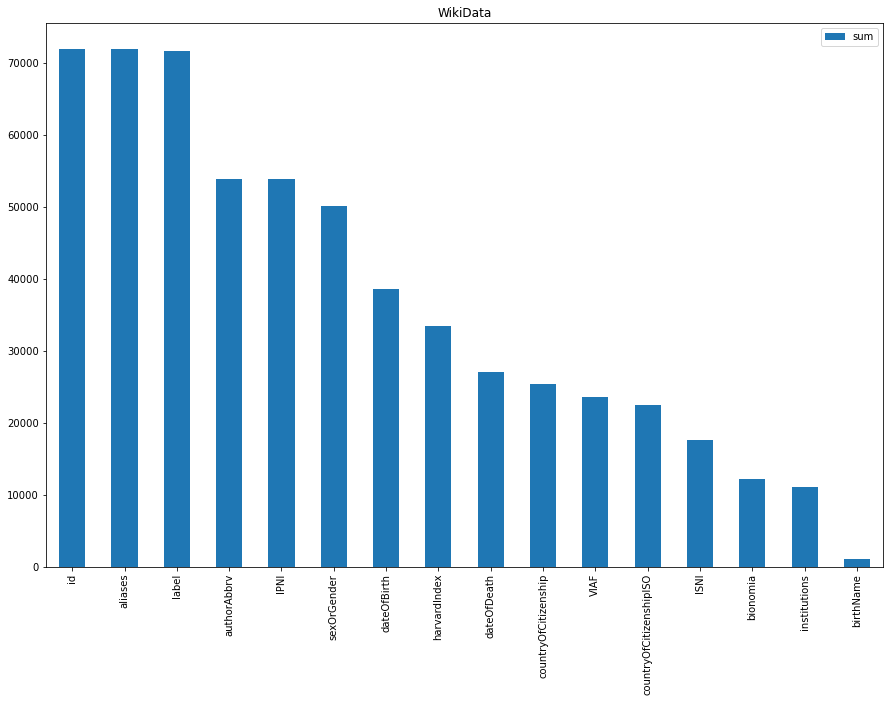

In [12]:
distribution = get_distribution(wiki_data, wiki_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'WikiData')

                          sum
ASA Botanist ID         76496
id                      76496
Name                    76496
asa_category            76496
GUID                    76478
Full Name               76464
Standard/Label Name     76455
firstName               76286
lastName                72365
Remarks                 60048
geographyISO            52834
geographyCombined       52834
Citation as Collector   50875
herbariaCode            45774
institutionUUID         45774
Geography Collector     42389
middleName              37869
Author name             36057
Specialty Author        35855
B & P Author Abbrev.    35793
Citation as Author      35606
birthYear               32890
birthYearIsApprox       32890
Date of birth           32890
Geography Author        18718
Specialty Collector     17798
Date of death           17210
deathYear               17210
deathYearIsApprox       17210
Collections in          15122
Holdings                15122
Collector Teams:        14534
First date

<AxesSubplot:title={'center':'Harvard Index'}>

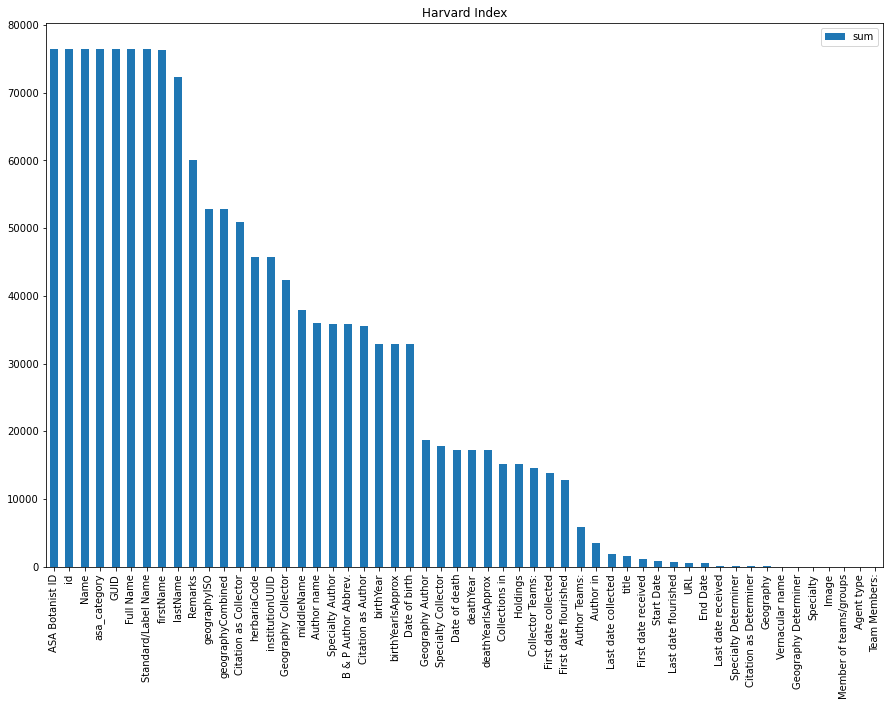

In [13]:
distribution = get_distribution(harvard_data, harvard_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Harvard Index')

In [ ]:
distribution = get_distribution(bionomia_data, bionomia_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10), title = 'Bionomia Index')

In [14]:
harvard_data.iloc[[10000]].T

,10000
ASA Botanist ID,144700 botanist
Author Teams:,NaN
Author name,H. P. G. Koch
B & P Author Abbrev.,H. P. G. Koch
Citation as Author,"Authors of Plant Names. Royal Botanic Gardens,..."
Collector Teams:,NaN
First date flourished,NaN
Full Name,"Koch, Hans Peter Gyllembourg"
GUID,http://purl.oclc.org/net/edu.harvard.huh/guid/...
Geography Author,NaN


In [17]:
print(wiki_columns)
print(harvard_columns)
print(bionomia_columns)

['id', 'label', 'institutions', 'dateOfBirth', 'ISNI', 'countryOfCitizenshipISO', 'countryOfCitizenship', 'aliases', 'bionomia', 'dateOfDeath', 'sexOrGender', 'VIAF', 'IPNI', 'harvardIndex', 'authorAbbrv', 'birthName']
['ASA Botanist ID', 'Author Teams:', 'Author name', 'B & P Author Abbrev.', 'Citation as Author', 'Collector Teams:', 'First date flourished', 'Full Name', 'GUID', 'Geography Author', 'Member of teams/groups', 'Name', 'Remarks', 'Specialty Author', 'Standard/Label Name', 'asa_category', 'id', 'Citation as Collector', 'Collections in', 'Date of birth', 'Geography Collector', 'Holdings', 'Specialty Collector', 'First date collected', 'Date of death', 'Author in', 'Agent type', 'Team Members:', 'Start Date', 'Last date collected', 'First date received', 'Geography Determiner', 'Specialty Determiner', 'Last date received', 'URL', 'End Date', 'Last date flourished', 'Specialty', 'Citation as Determiner', 'Geography', 'Vernacular name', 'Image', 'birthYear', 'birthYearIsApprox

In [8]:
a = wiki_data[['id','label','dateOfBirth','dateOfDeath','countryOfCitizenshipISO',
              'harvardIndex','bionomia','authorAbbrv','aliases']].copy()
a['firstName'] = a['label'].str.split('\s+').str[0]
a['lastName'] = a['label'].str.split('\s+').str[-1]
a['dateOfBirth'] = convert_date2year(a,'dateOfBirth')
a['dateOfDeath'] = convert_date2year(a,'dateOfDeath')
a['aliases'] = remove_spec_in_col(a,'aliases')
a['countryOfCitizenshipISO'] = remove_spec_in_col(a,'countryOfCitizenshipISO')
a.head()

,id,label,dateOfBirth,dateOfDeath,countryOfCitizenshipISO,harvardIndex,bionomia,authorAbbrv,aliases,firstName,lastName
0,Q100142069,Frida Eggens,NaN,NaN,SE,NaN,NaN,Eggens,Eggens,Frida,Eggens
1,Q100146795,Elizabeth Harrison,1792.0,1834.0,GB,NaN,Q100146795,NaN,"Mrs Arnold Harrison, Mrs A. H.",Elizabeth,Harrison
2,Q100149196,Russell Cox,NaN,NaN,NaN,NaN,0000-0001-5149-1709,NaN,,Russell,Cox
3,Q100152296,Alda Pereira da Fonseca,1882.0,NaN,BR,NaN,NaN,NaN,,Alda,Fonseca
4,Q100156193,Laurence Henry Millener,1914.0,2000.0,NZ,NaN,Q100156193,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ...",Laurence,Millener


In [9]:
b = harvard_data[['id','Standard/Label Name','birthYear','deathYear','birthYearIsApprox','geographyISO',
                 'firstName','middleName','lastName','B & P Author Abbrev.','Name']].copy()
b['Name'] = remove_spec_in_col(b,'Name')
b['geographyISO'] = remove_spec_in_col(b,'geographyISO')
b.head()

,id,Standard/Label Name,birthYear,deathYear,birthYearIsApprox,geographyISO,firstName,middleName,lastName,B & P Author Abbrev.,Name
0,89438,Shin. Sato,NaN,NaN,NaN,DE,Shinya,NaN,Sato,Shin. Sato,"Sato, Shinya, Shinya Sato"
1,64680,E. J. Hoffman,NaN,NaN,NaN,NaN,Emily,J.,Hoffman,E. J. Hoffman,"Hoffman, Emily J., Emily J. Hoffman"
2,34653,D. W. Stevenson,1942.0,NaN,False,US,Dennis,William,Stevenson,D. W. Stev.,"Stevenson, Dennis William, Dennis William Stev..."
3,42819,D. Müller-Doblies,1938.0,NaN,False,DE,Dietrich,NaN,Müller-Doblies,D. Müll.-Doblies,"Müller-Doblies, Dietrich, Dietrich Müller-Do..."
4,82862,Boutroux,NaN,NaN,NaN,NaN,A.,NaN,Boutroux,Boutroux,"Boutroux, A., A. Boutroux"


In [174]:
a = pd.read_csv('~/Downloads/a.csv',chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
a = pd.concat(a)
a['wikiID'] = a['id']
a = a.set_index('id')

b = pd.read_csv('~/Downloads/b.csv',chunksize=10000,encoding='utf-8',on_bad_lines='skip',engine='python')
b = pd.concat(b)
b['harvardIndex'] = b['id']
b = b.set_index('id')

In [175]:
a.head()

,label,dateOfBirth,dateOfDeath,countryOfCitizenshipISO,harvardIndex,bionomia,authorAbbrv,aliases,firstName,lastName,wikiID
id,,,,,,,,,,,
Q100142069,Frida Eggens,NaN,NaN,SE,NaN,NaN,Eggens,Eggens,Frida,Eggens,Q100142069
Q100146795,Elizabeth Harrison,1792.0,1834.0,GB,NaN,Q100146795,NaN,"Mrs Arnold Harrison, Mrs A. H.",Elizabeth,Harrison,Q100146795
Q100149196,Russell Cox,NaN,NaN,NaN,NaN,0000-0001-5149-1709,NaN,NaN,Russell,Cox,Q100149196
Q100152296,Alda Pereira da Fonseca,1882.0,NaN,BR,NaN,NaN,NaN,NaN,Alda,Fonseca,Q100152296
Q100156193,Laurence Henry Millener,1914.0,2000.0,NZ,NaN,Q100156193,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ...",Laurence,Millener,Q100156193


In [176]:
b.head()

,Standard/Label Name,birthYear,deathYear,birthYearIsApprox,geographyISO,firstName,middleName,lastName,B & P Author Abbrev.,Name,harvardIndex
id,,,,,,,,,,,
89438,Shin. Sato,NaN,NaN,NaN,DE,Shinya,NaN,Sato,Shin. Sato,"Sato, Shinya, Shinya Sato",89438
64680,E. J. Hoffman,NaN,NaN,NaN,NaN,Emily,J.,Hoffman,E. J. Hoffman,"Hoffman, Emily J., Emily J. Hoffman",64680
34653,D. W. Stevenson,1942.0,NaN,False,US,Dennis,William,Stevenson,D. W. Stev.,"Stevenson, Dennis William, Dennis William Stev...",34653
42819,D. Müller-Doblies,1938.0,NaN,False,DE,Dietrich,NaN,Müller-Doblies,D. Müll.-Doblies,"Müller-Doblies, Dietrich, Dietrich Müller-Do...",42819
82862,Boutroux,NaN,NaN,NaN,NaN,A.,NaN,Boutroux,Boutroux,"Boutroux, A., A. Boutroux",82862


In [16]:
a['harvardIndex'] = pd.to_numeric(a['harvardIndex'],errors='coerce') 
temp = pd.merge(a, b, how='inner', on=None, left_on='harvardIndex', right_on='harvardIndex',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

print(temp.columns.to_list())
temp.head()

['label', 'dateOfBirth', 'dateOfDeath', 'countryOfCitizenshipISO', 'harvardIndex', 'bionomia', 'authorAbbrv', 'aliases', 'firstName_wiki', 'lastName_wiki', 'wikiID', 'Standard/Label Name', 'birthYear', 'deathYear', 'birthYearIsApprox', 'geographyISO', 'firstName_harvard', 'middleName', 'lastName_harvard', 'B & P Author Abbrev.', 'Name']


,label,dateOfBirth,dateOfDeath,countryOfCitizenshipISO,harvardIndex,bionomia,authorAbbrv,aliases,firstName_wiki,lastName_wiki,...,Standard/Label Name,birthYear,deathYear,birthYearIsApprox,geographyISO,firstName_harvard,middleName,lastName_harvard,B & P Author Abbrev.,Name
0,Johann Bartsch,1709.0,1738.0,DE,27614.0,NaN,Bartsch,"Johannes Bartsch, Joannes Bartsch, Bartsch",Johann,Bartsch,...,J. Bartsch,1709.0,1738.0,False,NaN,Johann,NaN,Bartsch,Bartsch,"Bartsch, Johann, Johann Bartsch"
1,Townshend Stith Brandegee,1843.0,1925.0,US,17284.0,Q1002345,Brandegee,"Brandegee, T. S. Brandegee, Townshend S. Brand...",Townshend,Brandegee,...,T. S. Brandegee,1843.0,1925.0,False,"MX, US",Townshend,Stith,Brandegee,Brandegee,"Brandegee, Townshend Stith, Townshend Stith Br..."
2,Cécile Kruyfhooft,1950.0,NaN,BE,18988.0,NaN,NaN,NaN,Cécile,Kruyfhooft,...,C. Kruyfhooft,1950.0,NaN,False,BE,Cecile,NaN,Kruyfhooft,NaN,"Kruyfhooft, Cecile"
3,Charles Bullard,1869.0,1960.0,US,3553.0,Q100354624,NaN,C. Bullard,Charles,Bullard,...,Charles Bullard,1869.0,NaN,False,US,Charles,NaN,Bullard,NaN,"Bullard, Charles"
4,Zubair Aslam,NaN,NaN,NaN,88384.0,NaN,NaN,NaN,Zubair,Aslam,...,Z. Aslam,NaN,NaN,NaN,KR,Zubair,NaN,Aslam,Aslam,"Aslam, Zubair"


In [17]:
'''
use the pd.merge above to prepare training data -- find out the index true pairs
training = 0.9, testing = 0.1, no validat set

experiment setting
    - supervised: Logistics regression, navie bayes, SVM
    - undupervised: k-mean, ECM

refs
https://recordlinkage.readthedocs.io/en/latest/ref-classifiers.html
https://recordlinkage.readthedocs.io/en/latest/guides/classifiers.html#
'''

def define_true_pairs(indexList1, indexList2, indexName1, indexName2):
    arrays = [indexList1, indexList2]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=[indexName1, indexName2])
    return index

In [170]:
def find_AinB(df1, col1, df2, col2, threshold):
    newCol = []
    for index1, rowValue1 in df1[col1].iteritems():
        temp = []
        for index2, rowValue2 in df2[col2].iteritems():
            # 
            sim = process.extractOne(str(rowValue1),str(rowValue2).split(','), scorer=fuzz.ratio)
            if sim[-1] >= threshold: temp.append(index2)
        newCol.append(temp)
    return newCol

In [136]:
from recordlinkage.base import BaseCompareFeature

class CompareAliases(BaseCompareFeature):

    def __init__(self, left_on, right_on, threshold, *args, **kwargs):
        super(CompareAliases, self).__init__(left_on, right_on, *args, **kwargs)

        self.threshold = threshold

    def _compute_vectorized(self, s1, s2):
        """Compare aliases

        Use fuzzy model the compute the similarity between the given name string 
        and the elements in the aliases name list, return the one with the highest 
        matched score
        """

        # aliases = s2.str.split(',')
        # print(s1.get_loc())
        # print(s2[0])
        sim_turple = process.extractOne(s1[0],s2[0], scorer=fuzz.ratio)
        sim = sim_turple[0][-1] # index -1 refers to the last element of the turple in the list
        if float(sim) >= self.threshold: sim = 1
        else: sim = 0

        return sim

In [141]:
dfa = a.head(500)
dfb = b.head(500)
indexer = recordlinkage.Index()
indexer.block('lastName')# indexer.sortedneighbourhood
candidate_links = indexer.index(dfa, dfb)
compare_cl = recordlinkage.Compare()
compare_cl.string('firstName', 'firstName', method='jarowinkler', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'birthYear', label='dateOfBirth')
compare_cl.exact('harvardIndex', 'harvardIndex', label='harvardIndex')
compare_cl.string('authorAbbrv', 'B & P Author Abbrev.', method='jarowinkler', threshold=0.85, label='authorAbbrv')
# compare_cl.add(CompareAliases('label', 'Name', threshold=0.85, label='sim'))

features = compare_cl.compute(candidate_links, dfa, dfb)
features.sum(axis=1).value_counts().sort_index(ascending=False)
ecm = recordlinkage.ECMClassifier()
matches = ecm.fit_predict(features)
print(matches)

MultiIndex([('Q10377889', 80590)],
           names=['id_1', 'id_2'])


In [138]:
sim = process.extract(a['label']['Q21515530'],a['aliases']['Q21515530'].split(','), scorer=fuzz.ratio)
sim[0][-1] # index -1 refers to the last element of the turple in the list

In [ ]:
temp = find_AinB(a, 'label', b, 'Name', 85)

In [150]:
b['Name'].value_counts(dropna=False)

Jensen                                                             6
Jones                                                              5
Smith, C.                                                          5
Williams, C.                                                       4
Wilson, J.                                                         4
                                                                  ..
Broek, C. van den                                                  1
Lawrey, James D.                                                   1
Pillot, H. Moller                                                  1
Tsamajain, Luis                                                    1
Hubbard, Charles Edward, Charles Edward Hubbard, Hubbard, C. E.    1
Name: Name, Length: 76152, dtype: int64

In [159]:
a= process.extractOne(' ','fheiuhe, rowValue1'.split(','), scorer=fuzz.ratio)
print(a)

('fheiuhe', 0)


In [46]:
for s in b['Name'][63871].split(','): print(fuzz.ratio(b['Standard/Label Name'][63871],s))

'Ratzeburg, Julius Theodor Christian, Julius Theodor Christian Ratzeburg'

In [55]:
process.extract(b['Standard/Label Name'][63871], b['Name'][63871].split(','), scorer=fuzz.ratio)

[('Ratzeburg', 100),
 (' Julius Theodor Christian Ratzeburg', 42),
 (' Julius Theodor Christian', 18)]

In [21]:
define_true_pairs(temp['wikiID'],temp['harvardIndex'].astype(int),'wikiIndex','harvardIndex')

MultiIndex([(   'Q100222', 27614),
            (  'Q1002345', 17284),
            ('Q100255559', 18988),
            ('Q100354624',  3553),
            ('Q100377900', 88384),
            (   'Q100411', 23934),
            ('Q100454982', 50126),
            (   'Q100523', 78274),
            ('Q100587885', 29015),
            ('Q100587966', 14467),
            ...
            (    'Q65219', 25324),
            (     'Q6527', 26300),
            (    'Q65302',  4297),
            (    'Q65400',  2192),
            (    'Q65402', 46610),
            (    'Q65451',  1041),
            (    'Q65475', 38017),
            (    'Q65505', 80335),
            (     'Q6694',  1813),
            (     'Q7324',  8283)],
           names=['wikiIndex', 'harvardIndex'], length=31022)

In [8]:
# recordlinkage

# keyerror: "label is not in dataframe" caused by base.py -- not solved, reproduced even with in-bulit dataset
# Error solved, 18.05 2nd Aug, caused by Compare function with non-matched column name defined from the dataframes

# define indexer rule of recordlinkage
# indexer = recordlinkage.Index()
# indexer.full()

# candidates = indexer.index(wiki_data, bionomia_data)
# print(len(candidates)) # total: 5639036004, never works, please replace with blocks

# candidates = indexer.index(a, b)
# print(len(candidates)) # 

indexer = recordlinkage.Index()
indexer.block('lastName')# indexer.sortedneighbourhood
candidate_links = indexer.index(a, b)
# print(len(candidates))

In [10]:
print(type(candidate_links))
print(candidate_links)

# ref: https://pandas.pydata.org/docs/user_guide/advanced.html
# check the above document to construct the true pairs

<class 'pandas.core.indexes.multi.MultiIndex'>
MultiIndex([('Q100146795', 10627),
            ('Q100146795', 67944),
            ('Q100146795', 88187),
            ('Q100146795', 65456),
            ('Q100146795', 20114),
            ('Q100146795', 78403),
            ('Q100146795', 63347),
            ('Q100146795', 44673),
            ('Q100146795', 15648),
            ('Q100146795', 32720),
            ...
            (    'Q65090',   567),
            (    'Q65090', 13247),
            (    'Q65090', 41700),
            (    'Q65095', 30293),
            (    'Q65149', 23011),
            (    'Q65173',  1546),
            (    'Q65451',  1041),
            (     'Q6694',  1813),
            (     'Q6694', 44644),
            (     'Q8619', 37068)],
           names=['id_1', 'id_2'], length=784820)


In [85]:
compare_cl = recordlinkage.Compare()
compare_cl.string('firstName', 'firstName', method='jarowinkler', threshold=0.85, label='firstName')
compare_cl.exact('dateOfBirth', 'birthYear', label='dateOfBirth')
# compare_cl.exact('harvardIndex', 'harvardIndex', label='harvardIndex')
compare_cl.string('authorAbbrv', 'B & P Author Abbrev.', method='jarowinkler', threshold=0.85, label='authorAbbrv')
# compare_cl.add(CompareAliases('label', 'Name', threshold=0.85, label='sim'))

features = compare_cl.compute(candidate_links, a, b)
features.sum(axis=1).value_counts().sort_index(ascending=False)

/var/folders/gf/wqsz1zkd6x95xx3fgy6qr2780000gn/T/ipykernel_13588/130639564.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  aliases = ''.join(s2.str)

KeyboardInterrupt



In [74]:
ecm = recordlinkage.ECMClassifier()
matches = ecm.fit_predict(features)
print(matches)

MultiIndex([('Q117328252', 23991),
            ( 'Q21393810', 74465),
            ( 'Q21515524', 67944),
            ( 'Q21515528',  5435),
            ( 'Q21515529', 83150),
            ( 'Q21515530', 65456),
            ( 'Q22111926', 78403),
            ( 'Q36626496', 63347),
            ( 'Q15983862', 72614),
            (   'Q177350', 82744),
            ...
            (    'Q64655', 63871),
            (    'Q64995',   417),
            (    'Q64999',  1369),
            (    'Q65090',   567),
            (    'Q65090', 13247),
            (    'Q65095', 30293),
            (    'Q65149', 23011),
            (    'Q65173',  1546),
            (    'Q65451',  1041),
            (     'Q6694',  1813)],
           names=['id_1', 'id_2'], length=36311)


In [39]:
ecm = recordlinkage.ECMClassifier()
matches = ecm.fit_predict(features)
print(matches)

MultiIndex([('Q117328239', 16297),
            ('Q117328252', 67944),
            ('Q117328252', 23991),
            ('Q117455304', 88187),
            ( 'Q21393810', 74465),
            ( 'Q21515524', 67944),
            ( 'Q21515524', 23991),
            ( 'Q21515528',  5435),
            ( 'Q21515529', 83150),
            ( 'Q21515530', 65456),
            ...
            (    'Q64655', 63871),
            (    'Q64995',   417),
            (    'Q64999',  1369),
            (    'Q65090',   567),
            (    'Q65090', 13247),
            (    'Q65095', 30293),
            (    'Q65149', 23011),
            (    'Q65173',  1546),
            (    'Q65451',  1041),
            (     'Q6694',  1813)],
           names=['id_1', 'id_2'], length=42650)


In [22]:
print(a.loc[['Q21515530']])
print()
print(b.loc[[63871]])

                                label  dateOfBirth  dateOfDeath  \
id                                                                
Q21515530  Travis Henry John Harrison       1901.0       1977.0   

          countryOfCitizenshipISO  harvardIndex bionomia     authorAbbrv  \
id                                                                         
Q21515530                     NaN           NaN      NaN  T.H.J.Harrison   

                  aliases firstName  lastName     wikiID  
id                                                        
Q21515530  T.H.J.Harrison    Travis  Harrison  Q21515530  

      Standard/Label Name  birthYear  deathYear birthYearIsApprox  \
id                                                                  
63871           Ratzeburg     1801.0     1871.0             False   

      geographyISO firstName         middleName   lastName  \
id                                                           
63871           DE    Julius  Theodor Christian  Ratzeburg 

In [38]:
print(features.sum(axis=1).value_counts().sort_index(ascending=False)) # abbrv, jarowinkler, 0.85

3.0     14220
2.0     20237
1.0     51974
0.0    698389
dtype: int64


In [36]:
print(features.sum(axis=1).value_counts().sort_index(ascending=False)) # firstname, jarowinkler, 0.80

3.0     11801
2.0     17395
1.0     21713
0.0    733911
dtype: int64


In [34]:
print(features.sum(axis=1).value_counts().sort_index(ascending=False)) # abbrv, damerau_levenshtein, 0.85

3.0     10783
2.0     15234
1.0     15541
0.0    743262
dtype: int64


In [32]:
print(features.sum(axis=1).value_counts().sort_index(ascending=False)) # firstname, jarowinkler, 0.85

3.0     11690
2.0     17086
1.0     18573
0.0    737471
dtype: int64


In [82]:
result2 = pd.merge(wiki_data, bionomia_data, how='inner', on=None, left_on='id', right_on='wikidata',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_bionomia'), copy=False, indicator=False)

result2

,id_wiki,label,institutions,dateOfBirth_wiki,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath_wiki,...,fullname,thumbnail,description,is_public,has_occurrences,orgs,countries,dateOfBirth_bionomia,dateOfDeath_bionomia,acceptedNames
0,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,...,Elizabeth Harrison,https://bionomia.net/images/photo24X24.png,British botanical illustrator and horticultura...,True,False,None,None,1792,1834,"[Mrs Arnold Harrison, Mrs A. H.]"
1,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,...,Laurence Henry Millener,https://bionomia.net/images/photo24X24.png,New Zealand university teacher and botanist (1...,True,True,None,None,1914,2000,"[L. H. Millener, Laurie Henry Millener, Laurie..."
2,Q100156252,Thomas Leonard Lancaster,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1888-00-00T00:00:00Z,NaN,['NZ'],['Q664'],['T. L. Lancaster'],Q100156252,+1945-00-00T00:00:00Z,...,Thomas Leonard Lancaster,https://bionomia.net/images/photo24X24.png,New Zealand university teacher and botanist (1...,True,True,None,None,1888,1945,[T. L. Lancaster]
3,Q100157099,Ross Henry Michie,NaN,+1894-00-00T00:00:00Z,NaN,['NZ'],['Q664'],"['Ross Michie', 'R. H. Michie']",Q100157099,+1987-00-00T00:00:00Z,...,Ross Henry Michie,https://bionomia.net/images/photo24X24.png,New Zealand botanist and botanical collector (...,True,True,None,None,1894,1987,"[Ross Michie, R. H. Michie]"
4,Q100222,Johann Bartsch,NaN,+1709-01-01T00:00:00Z,0000 0000 6454 2176,['DE'],['Q183'],"['Johannes Bartsch', 'Joannes Bartsch', 'Barts...",NaN,+1738-01-01T00:00:00Z,...,Johann Bartsch,https://bionomia.net/images/photo24X24.png,German physician and botanist (1709-1738),False,False,None,None,1709,1738,"[Joannes Bartsch, Johannes Bartsch, Bartsch]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23868,Q6694,Alexander von Humboldt,[],+1769-09-14T00:00:00Z,0000 0001 2144 1671,NaN,['Q27306'],['Friedrich Wilhelm Heinrich Alexander von Hum...,Q6694,+1859-05-06T00:00:00Z,...,Friedrich Wilhelm Heinrich Alexander von von H...,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,"Prussian geographer, naturalist and explorer (...",True,True,None,None,1769,1859,"[Alexander von Humboldt, Friedrich Wilhelm Hei..."
23869,Q7324,James Cook,NaN,+1728-10-27T00:00:00Z,0000 0001 2277 9981,NaN,['Q161885'],"['Captain James Cook', 'Cook', 'Captain Cook',...",Q7324,+1779-02-14T00:00:00Z,...,James Cook,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,British explorer (1728–1779),True,True,None,None,1728,1779,"[James Cook, Captain James Cook, Cook, Captain..."
23870,Q762,Leonardo da Vinci,[],+1452-04-15T00:00:00Z,0000 0001 2124 423X,NaN,['Q148540'],"['Leonardo di ser Piero da Vinci', 'Leonardo',...",NaN,+1519-05-02T00:00:00Z,...,Leonardo da Vinci,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,Italian Renaissance polymath (1452−1519),False,False,None,None,1452,1519,"[Leonardo da Vinci, Leonardo di ser Piero da V..."
23871,Q8619,Pierre Trudeau,[],+1919-10-18T00:00:00Z,0000 0001 1021 4967,['CA'],['Q16'],"['Pierre Elliott Trudeau', 'Joseph Philippe Pi...",Q8619,+2000-09-28T00:00:00Z,...,Pierre Elliott Trudeau,https://abekpgaoen.cloudimg.io/crop/24x24/n/ht...,15th Prime Minister of Canada (1919-2000),True,True,None,None,1919,2000,"[Pierre Elliott Trudeau, Joseph Philippe Pierr..."


In [ ]:
cols_to_drop = ['Unnamed: 0.1','Unnamed: 0','Geography Author', 'Geography Collector', 'Geography Determiner', 
                  'Geography','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty',
                  'Remarks',]
harvard_data.drop(cols_to_drop, axis=1, inplace=True)

In [84]:
# fuzz.token_set_ratio("Davis, Helen Burns", "helen burns davis")
temp = wiki_data.iloc[[120]].T
print(temp)
temp = harvard_data.iloc[[10000]].T
print(temp)

                                           120
id                                  Q101069525
label                          Even Trætteberg
institutions                               NaN
dateOfBirth              +1871-02-08T00:00:00Z
ISNI                                       NaN
countryOfCitizenshipISO                 ['NO']
countryOfCitizenship                   ['Q20']
aliases                                     []
bionomia                            Q101069525
dateOfDeath              +1949-02-08T00:00:00Z
sexOrGender                               male
VIAF                                       NaN
IPNI                                       NaN
harvardIndex                               NaN
authorAbbrv                                NaN
birthName                                  NaN
                                                                    10000
Unnamed: 0.1                                                        10000
Unnamed: 0                                           

In [23]:
text1 = "[author note: Types at: MT] [collector note: col. with M. St-Arnaud; MT; BO]"
text2 = "[collector note: Herbarium (Piedmont (Italy): TO]"
text3 = "[collector note: SAFB] plant pathologist; short biography and photo: Can. J. Plant Pathol. Vol. 28: S21-S22. 2006."
text4 = "[collector note: BM-SL, OXF.]"
text5 = "[collector note: Herbarium and types, US, additional m,erial , B, C, DBN, GH, K, MIN, MO, NA, NY, PH"
text = "[author note: LE; temperate Asian Polygonaceae] [collector note: LE] "
temp = text4.split("[")
s1 = ""
s2 = ""
print(temp)
for i in temp:
    # i = clean_text(i)
    print("\nFor loop: " + i)
    s1 = i.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',')
    print("author note: ", get_herbarium_codes(s1))
    
    s2 = i.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',')
    print("collector note: ", get_herbarium_codes(s2))

'''
# not robust enough comparing to the inbulid string partitioning
import re
m = re.search('author note: (.+?);', text)
if m:
    found = m.group(1)
print(found.replace(";", ''))
'''
s1 = get_author_notes(temp)
s2 = get_collector_notes(temp)
print("\nFunction version:")
print("author note: ", s1)
for i in s1: print("\nHerbarium List: ", get_herbarium_codes(i))
print("collector note: ", s2)
for i in s2: print("\nHerbarium List: ", get_herbarium_codes(i))

['', 'collector note: BM-SL, OXF.]']

For loop: 
author note:  []
collector note:  []

For loop: collector note: BM-SL, OXF.]
author note:  []
collector note:  ['BMSL', 'OXF']

Function version:
author note:  []
collector note:  ['BM-SL, OXF.']

Herbarium List:  ['BMSL', 'OXF']


In [9]:
# Functions to extract the herbarium institution codes from Remarks in Harvard Index
def get_herbarium_codes(string):
    herbarium_codes = []
    for s in string.split(","):
        if s.isupper():
            herbarium_codes.append(re.sub('[^A-Z]', ',', s).replace(",",""))
    return herbarium_codes
            
def get_author_notes(string):
    authorNotes = []
    for s in string:
        # s = clean_text(s)
        # authorNotes.append(s.partition("author note: ")[2].partition(" ")[0].replace(";", ''))
        authorNotes.append(s.partition("author note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    authorNotes = list(filter(None, authorNotes))
    return authorNotes

def get_collector_notes(string):
    collectorNotes = []
    for s in string:
        # s = clean_text(s)
        # collectorNotes.append(s.partition("collector note: ")[2].partition(" ")[0].replace(";", ''))
        collectorNotes.append(s.partition("collector note: ")[2].partition("]")[0].replace(";", ',').replace(":", ',').replace("(",",").replace(")",",").replace("at",","))
    collectorNotes = list(filter(None, collectorNotes))
    return collectorNotes

def get_author_collector_notes(df, col):
    authorNoteCol = []
    collectorNoteCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            string = rowValue.split("[")
            authorNoteCol.append(get_author_notes(string))
            collectorNoteCol.append(get_collector_notes(string))
        else:
            authorNoteCol.append([]) # use empty to reduce runtime exception while condition checking
            collectorNoteCol.append([])
    return authorNoteCol, collectorNoteCol

def extract_herbariums(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if rowValue:
            temp = []
            # for i in rowValue: temp = get_herbarium_codes(i)
            for i in rowValue: 
                temp += get_herbarium_codes(i)
            newCol.append(temp)
        else:
            newCol.append([])
    return newCol

In [14]:
temp = harvard_data[['id', 'Remarks']].copy()
print(temp)

a, b = get_author_collector_notes(temp, 'Remarks')

           id                                            Remarks
0       47342                              [collector note: SGO]
1       14911  [collector note: Herbarium (Piedmont (Italy): TO]
2       29488                      [collector note: BM-SL, OXF.]
3       44660  [collector note: Ontario, Algoma Dist., Thunde...
4       10131              [collector note: Type collection: FH]
...       ...                                                ...
114288  98272                                                NaN
114289  98278                                                NaN
114290  98280                               [collector note: TN]
114291  98286                                              (LAE)
114292  98287                               [collector note: MN]

[114293 rows x 2 columns]


In [78]:
a, b = get_author_collector_notes(harvard_data, 'Remarks')
harvard_data['author note'] = a
harvard_data['collector note'] = b

In [8]:
harvard_data['author note'] = extract_herbariums(harvard_data,'author note')

/var/folders/gf/wqsz1zkd6x95xx3fgy6qr2780000gn/T/ipykernel_51973/411441977.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.notnull(rowValue):


In [60]:
temp = harvard_data[['id', 'collector note']].copy()
temp.to_csv('test_file.csv', sep=',', encoding='utf-8')

In [57]:
temp = ['h','w']
temp1 = []
temp2 = np.nan
if temp2:
    if pd.notnull(temp):
        temp = np.nan
        print(temp)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [4]:
# Replace empty list as np.nan
def remove_empty(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if not rowValue:
            newCol.append(np.nan)
        else:
            newCol.append(rowValue)
    return newCol

In [91]:
b = harvard_data[['id', 'collector note']].copy()
b['collector note'] = extract_herbariums(b,'collector note')

In [92]:
a = harvard_data[['id', 'author note']].copy()
a['author note'] = extract_herbariums(a,'author note')

In [93]:
a['author note'].value_counts()

[]                                                                                               104352
[K]                                                                                                 180
[B]                                                                                                 130
[BM]                                                                                                108
[MO]                                                                                                107
                                                                                                  ...  
[BM, AK, BERN, CGE, DBN, DPU, E, EBH, FI, FRS, G, K, KIEL, L, MANCH, NEU, NMW, OXF, PH, U, W]         1
[S, GB, NMW]                                                                                          1
[MPU, AL, FI, LY, P, W]                                                                               1
[MSTR, B, BHU, BR, BREM, DBN, E, FI, GB, GOET, H, HAL, KIEL, LE,

In [81]:
a['author note'].value_counts()

[]                                                                                               104352
[K]                                                                                                 180
[B]                                                                                                 130
[BM]                                                                                                108
[MO]                                                                                                107
                                                                                                  ...  
[BM, AK, BERN, CGE, DBN, DPU, E, EBH, FI, FRS, G, K, KIEL, L, MANCH, NEU, NMW, OXF, PH, U, W]         1
[S, GB, NMW]                                                                                          1
[MPU, AL, FI, LY, P, W]                                                                               1
[MSTR, B, BHU, BR, BREM, DBN, E, FI, GB, GOET, H, HAL, KIEL, LE,

In [82]:
b['collector note'].value_counts()

[]                57251
[FH]               1824
[NEBC]             1273
[A]                1267
[K]                1176
                  ...  
[BPI, NY, PAV]        1
[MB, FH]              1
[GOET, KR]            1
[CAS, L, US]          1
[DC, FH]              1
Name: collector note, Length: 16578, dtype: int64

In [94]:
b['collector note'].value_counts()

[]                             57249
[FH]                            1824
[NEBC]                          1273
[A]                             1267
[K]                             1176
                               ...  
[MB, FH]                           1
[GOET, KR]                         1
[CAS, L, US]                       1
[B, BM, C, DAO, L, M, S, W]        1
[DC, FH]                           1
Name: collector note, Length: 16580, dtype: int64

In [ ]:
temp = b[['id', 'collector note']].copy()
temp.to_csv('test_file.csv', sep=',', encoding='utf-8')

In [124]:
temp = harvard_data['Remarks'].value_counts()
print(temp)

[author note: Herbarium and types unknown]                                                                            2492
[collector note: BR]                                                                                                   406
[collector note: A]                                                                                                    383
[collector note: MO]                                                                                                   379
[collector note: K]                                                                                                    293
                                                                                                                      ... 
[author note: LE; temperate Asian Polygonaceae] [collector note: LE]                                                     1
[collector note: E (col. 1934)]                                                                                          1
[author note: Ty

In [11]:
# Extract geography locations and travel history related to collectors
def combine_geography(df):
    cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('\xa0 ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [63]:
temp = harvard_data[['id','Name','Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']].copy()
cols = ['Geography Author', 'Geography Collector', 'Geography Determiner', 'Geography']
temp['combine_geography'] = combine_geography(temp)
temp['combine_geography'].value_counts().index.tolist()

[{''},
 {'United States of America'},
 {'Brazil'},
 {'China'},
 {'Germany'},
 {'Mexico'},
 {'Canada'},
 {'France'},
 {'India'},
 {'Australia (Country)'},
 {'Colombia'},
 {'Russia'},
 {'Indonesia'},
 {'California'},
 {'Japan'},
 {'Argentina'},
 {'South Africa'},
 {'Italy'},
 {'Sweden'},
 {'Malaysia'},
 {'Ecuador'},
 {'Peru'},
 {'Venezuela'},
 {'Spain'},
 {'Papua New Guinea'},
 {'Czech Republic'},
 {'Netherlands'},
 {'Switzerland'},
 {'Philippines'},
 {'Finland'},
 {'Costa Rica'},
 {'Belgium'},
 {'Austria'},
 {'Panama'},
 {'Denmark'},
 {'Cuba'},
 {'Bolivia'},
 {'Poland'},
 {'New Zealand'},
 {'Thailand'},
 {' Democratic Republic of the', 'Congo'},
 {'Mexico', 'United States of America'},
 {'Chile'},
 {'Portugal'},
 {'Norway'},
 {'Turkey'},
 {'Canada', 'United States of America'},
 {'Hungary'},
 {'Madagascar'},
 {'Nigeria'},
 {'United Kingdom'},
 {'Nepal'},
 {'Vietnam'},
 {'Ireland'},
 {'Tanzania'},
 {'Pakistan'},
 {'Jamaica'},
 {'Iran'},
 {'Romania'},
 {'Kenya'},
 {'Greenland'},
 {'Guyana

In [64]:
temp['combined'].value_counts()

{}                                           34818
{United States of America}                   17940
{Brazil}                                      3261
{China}                                       2922
{Germany}                                     2717
                                             ...  
{Norway, Greenland, Switzerland, Denmark}        1
{Netherlands, Thailand, Indonesia}               1
{Sierra Leone, Germany, Cameroon}                1
{India, Greece, Hungary}                         1
{Quebec Province, New York}                      1
Name: combined, Length: 4072, dtype: int64

In [17]:
temp = harvard_data['Geography Author'].value_counts()
print(temp)
print()
temp = harvard_data['Geography Collector'].value_counts()
print(temp)
print()
temp = harvard_data['Geography Determiner'].value_counts()
print(temp)
print()
temp = harvard_data['Geography'].value_counts()
print(temp)

United States of America                                               3644
Germany                                                                2440
France                                                                 1348
China                                                                  1197
India                                                                   909
                                                                       ... 
Belgium,  Cuba,  Czech Republic,  Mexico,  United States of America       1
Costa Rica,  Ecuador,  Guatemala,  United States of America               1
France,  Madagascar,  Vietnam                                             1
Argentina,  Brazil,  Chile                                                1
Africa (Region)                                                           1
Name: Geography Author, Length: 974, dtype: int64

United States of America                                                          12178
Brazil                   

In [51]:
temp = harvard_data[['id','Name','Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']].copy()
cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
# temp['combined'] = temp['Specialty Author'].combine_first(temp['Specialty Collector']).combine_first(temp['Specialty Determiner']).combine_first(temp['Specialty'])
temp['combined'] = temp[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
temp['combined'].value_counts().index.tolist()

['',
 'Spermatophytes',
 'Phanerogams',
 'Fungi and Lichens',
 'Algae',
 'Spermatophytes,Phanerogams',
 'Bryophytes',
 'Fungi',
 'Pteridophytes',
 'Lichens',
 'Fossils',
 'FungiAndLichens',
 'Fungi and Lichens,Fungi',
 'Angiosperms',
 'Spermatophytes,Pteridophytes',
 'Fungi and Lichens,Lichens',
 'Mosses',
 'Spermatophytes,Lichens',
 'Spermatophytes,Fungi',
 'Diatoms',
 'Pre-Linnean',
 'Hepatics',
 'Spermatophytes,Bryophytes',
 'Fungi and Lichens,Phanerogams',
 "['Phanerogams', 'Pteridophytes']",
 'Spermatophytes,Algae',
 'FungiAndLichens,Fungi',
 'Bryophytes,Phanerogams',
 'Pteridophytes,Phanerogams',
 'Algae,Phanerogams',
 'Bryophytes,Lichens',
 'Algae,Diatoms',
 'Fungi and Lichens,Bryophytes',
 'Bryophytes,Hepatics',
 'Cryptogamic, unspecified',
 'FungiAndLichens,Lichens',
 'Fungi and Lichens,Pteridophytes',
 "['Bryophytes', 'Phanerogams']",
 'FungiAndLichens,Phanerogams',
 'Algae,Lichens',
 'Fungi and Lichens,Algae',
 'Fossils,Phanerogams',
 'Pre-Linnean,Phanerogams',
 'Spermatophy

In [48]:
set(clean_text("Spermatophytes,['Bryophytes', 'Spermatophytes']").replace(' ','').split(','))

{'Bryophytes', 'Spermatophytes'}

In [12]:
# Extract specialty areas of collectors - for Harvard Index data preprocessing
def combine_specialty(df):
    cols = ['Specialty Author', 'Specialty Collector', 'Specialty Determiner', 'Specialty']
    newCol = df[cols].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        if pd.notnull(rowValue):
            newCol[index] = set(clean_text(rowValue).replace('And',',').replace(' and ',',').replace(' ','').split(','))
        else:
            newCol[index] = np.nan
    return newCol

In [59]:
temp['combine_specialty'] = combine_specialty(temp)

temp['combine_specialty'].value_counts().index.tolist()

[{''},
 {'Spermatophytes'},
 {'Phanerogams'},
 {'Fungi', 'Lichens'},
 {'Algae'},
 {'Phanerogams', 'Spermatophytes'},
 {'Bryophytes'},
 {'Fungi'},
 {'Pteridophytes'},
 {'Lichens'},
 {'Fossils'},
 {'Angiosperms'},
 {'Pteridophytes', 'Spermatophytes'},
 {'Mosses'},
 {'Lichens', 'Spermatophytes'},
 {'Fungi', 'Spermatophytes'},
 {'Diatoms'},
 {'Phanerogams', 'Pteridophytes'},
 {'Pre-Linnean'},
 {'Hepatics'},
 {'Bryophytes', 'Spermatophytes'},
 {'Fungi', 'Lichens', 'Phanerogams'},
 {'Bryophytes', 'Phanerogams'},
 {'Algae', 'Spermatophytes'},
 {'Algae', 'Phanerogams'},
 {'Bryophytes', 'Lichens'},
 {'Algae', 'Diatoms'},
 {'Bryophytes', 'Fungi', 'Lichens'},
 {'Bryophytes', 'Hepatics'},
 {'Cryptogamic', 'unspecified'},
 {'Fungi', 'Lichens', 'Pteridophytes'},
 {'Fungi', 'Lichens', 'Spermatophytes'},
 {'Algae', 'Bryophytes'},
 {'Fungi', 'Phanerogams'},
 {'Algae', 'Lichens'},
 {'Fossils', 'Phanerogams'},
 {'Algae', 'Pteridophytes'},
 {'Algae', 'Fungi', 'Lichens'},
 {'Phanerogams', 'Pre-Linnean'},
 

In [18]:
temp = harvard_data['Specialty Author'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty Collector'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty Determiner'].value_counts()
print(temp)
print()
temp = harvard_data['Specialty'].value_counts()
print(temp)

Spermatophytes              22105
Fungi and Lichens            8503
Algae                        3949
Bryophytes                   1033
Fossils                       968
Pteridophytes                 659
FungiAndLichens               588
Fungi                         107
Pre-Linnean                   106
Diatoms                        31
Phanerogams                    28
Lichens                        23
Cryptogamic, unspecified       20
Mosses                         13
Hepatics                        7
Angiosperms                     4
PreLinnean                      1
Name: Specialty Author, dtype: int64

Phanerogams        12265
Spermatophytes      7154
Fungi               1968
Lichens             1436
Bryophytes          1372
Pteridophytes       1297
Algae                750
FungiAndLichens      203
Angiosperms          200
Diatoms              114
Hepatics              96
Mosses                95
Fossils                6
Name: Specialty Collector, dtype: int64

Spermatophytes    

In [51]:
ts = pd.Timestamp('1953-01-01T00:00:00Z')
pd.isnull(wiki_data.at[1, 'dateOfBirth'])
type('1953-01-01T00:00:00Z')

str

In [144]:
a = wiki_data.at[1, 'dateOfBirth'] 
print(a)
a = wiki_data['dateOfBirth'][1] 
print(a)
a = wiki_data.at[1, 'dateOfBirth'][1:11]
print(int(a[8:10]))
# a = '1953-01-01T00:00:00Z'
if int(a[8:10]) == 0:
    print(pd.Timestamp(year=int(a[0:4]),month=int(a[5:7]),day=1))

+1792-12-00T00:00:00Z
+1792-12-00T00:00:00Z
0
1792-12-01 00:00:00


In [13]:
def get_timestamp(date_str):
    # Probably not necessary
    date_str = date_str.strip()
    # Remove + sign
    if date_str[0] == '+':
        date_str = date_str[1:]
    # Remove missing month/day
    date_str = date_str.split('-00', maxsplit=1)[0]
    # Parse date
    dt = np.datetime64(date_str)
    # As Unix timestamp (choose preferred datetype)
    return dt.astype('<M8[s]').astype(np.int64)

print('Timestamp for {}: {}'.format(wiki_data.at[1, 'dateOfBirth'][1:], get_timestamp(wiki_data.at[1, 'dateOfBirth'][1:])))

Timestamp for 1792-12-00T00:00:00Z: -5588179200


In [41]:
print(wiki_data['dateOfBirth'][1])
print(get_year(wiki_data['dateOfBirth'][1]))
print(harvard_data['Date of birth'][1])
print(get_year(harvard_data['Date of birth'][1]))

+1792-12-00T00:00:00Z
1792
1750
1750


In [17]:
a = wiki_data[['id', 'dateOfBirth']].copy()
a['dateOfBirthYear'] = convert_date2year(a,'dateOfBirth')
a

,id,dateOfBirth,dateOfBirthYear
0,Q100142069,NaN,NaN
1,Q100146795,+1792-12-00T00:00:00Z,1792.0
2,Q100149196,NaN,NaN
3,Q100152296,+1882-00-00T00:00:00Z,1882.0
4,Q100156193,+1914-04-01T00:00:00Z,1914.0
...,...,...,...
71983,Q7324,+1728-10-27T00:00:00Z,1728.0
71984,Q7450,+1917-09-23T00:00:00Z,1917.0
71985,Q762,+1452-04-15T00:00:00Z,1452.0
71986,Q8619,+1919-10-18T00:00:00Z,1919.0


In [253]:
a = wiki_data[['id', 'label','dateOfBirth','dateOfDeath']].copy()
a['firstnames'] = a['label'].str.split('\s+').str[0]
a['lastnames'] = a['label'].str.split('\s+').str[-1]
a['dateOfBirthYear'] = convert_date2year(a,'dateOfBirth')
a['dateOfDeathYear'] = convert_date2year(a,'dateOfDeath')
a.drop(['dateOfBirth', 'dateOfDeath'], axis=1, inplace=True)
a

,id,label,firstnames,lastnames,dateOfBirthYear,dateOfDeathYear
0,Q100142069,Frida Eggens,Frida,Eggens,NaN,NaN
1,Q100146795,Elizabeth Harrison,Elizabeth,Harrison,1792.0,1834.0
2,Q100149196,Russell Cox,Russell,Cox,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,Alda,Fonseca,1882.0,NaN
4,Q100156193,Laurence Henry Millener,Laurence,Millener,1914.0,2000.0
...,...,...,...,...,...,...
71983,Q7324,James Cook,James,Cook,1728.0,1779.0
71984,Q7450,Asima Chatterjee,Asima,Chatterjee,1917.0,2006.0
71985,Q762,Leonardo da Vinci,Leonardo,Vinci,1452.0,1519.0
71986,Q8619,Pierre Trudeau,Pierre,Trudeau,1919.0,2000.0


In [217]:
b = harvard_data[['id','Name','Date of birth','Date of death']].copy()
b['firstnames'] = b['Name'].str.split(', ').str[-1]
b['lastnames'] = b['Name'].str.split(', ').str[0]
b['firstnames'] = b['firstnames'].str.split('\s+').str[0]
b['dateOfBirthYear'] = convert_date2year(b,'Date of birth')
b['dateOfDeathYear'] = convert_date2year(b,'Date of death')
b.drop(['Date of birth', 'Date of death'], axis=1, inplace=True)
b

,id,Name,firstnames,lastnames,dateOfBirthYear,dateOfDeathYear
0,47342,"Hepp, R.",R.,Hepp,NaN,NaN
1,14911,"Palazzi, Andrea",Andrea,Palazzi,1750.0,1830.0
2,29488,"Nicholls, Robert",Robert,Nicholls,NaN,NaN
3,44660,"Hosie, R. C.",R.,Hosie,NaN,NaN
4,10131,"Lohman, M. L.",M.,Lohman,NaN,NaN
...,...,...,...,...,...,...
98685,14495,"Fonnegra G., Ramiro",Ramiro,Fonnegra G.,1947.0,NaN
98686,20182,"Hardy, J. Ray",J.,Hardy,NaN,NaN
98687,3194,"Moon, Gene",Gene,Moon,NaN,NaN
98688,10152,Koch,Koch,Koch,NaN,NaN


In [223]:
result2 = a.merge(b, how='inner', on=['firstnames','lastnames'])
result2_columns = result2.columns.tolist()
distribution = get_distribution(result2, result2_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
# temp.plot.bar(figsize=(15,10))
result2

                     sum
id_x               35110
id_y               35110
label              34118
firstnames         34118
lastnames          34118
Name               34118
dateOfBirthYear_x  23709
dateOfBirthYear_y  19978
dateOfDeathYear_x  16656
dateOfDeathYear_y  12125


,id_x,label,firstnames,lastnames,dateOfBirthYear_x,dateOfDeathYear_x,id_y,Name,dateOfBirthYear_y,dateOfDeathYear_y
0,Q100222,Johann Bartsch,Johann,Bartsch,1709.0,1738.0,27614,"Bartsch, Johann",1709.0,1738.0
1,Q1002345,Townshend Stith Brandegee,Townshend,Brandegee,1843.0,1925.0,17284,"Brandegee, Townshend Stith",1843.0,1925.0
2,Q100354624,Charles Bullard,Charles,Bullard,1869.0,1960.0,3553,"Bullard, Charles",1869.0,NaN
3,Q100377900,Zubair Aslam,Zubair,Aslam,NaN,NaN,88384,"Aslam, Zubair",NaN,NaN
4,Q100397018,Ralph Durham Bird,Ralph,Bird,1901.0,1972.0,98506,"Bird, Ralph Durham",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35105,Q65400,Gustav Kunze,Gustav,Kunze,1793.0,1851.0,2192,"Kunze, Gustav",1793.0,1851.0
35106,Q65402,Karl Friedrich Schimper,Karl,Schimper,1803.0,1867.0,46610,"Schimper, Karl Friedrich",1803.0,1867.0
35107,Q65402,Karl Friedrich Schimper,Karl,Schimper,1803.0,1867.0,2853,"Schimper, Karl Friedrich",1803.0,1867.0
35108,Q65451,Georg Wolfgang Franz Panzer,Georg,Panzer,1755.0,1829.0,1041,"Panzer, Georg Wolfgang Franz",1755.0,1829.0


In [263]:
merged = pd.merge(result2, c, indicator=True, how='outer', left_on=['firstnames','lastnames'], right_on=['firstnames_h','lastnames_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:        id_x label_x firstnames lastnames  dateOfBirthYear_x  dateOfDeathYear_x  \
50957  NaN     NaN        NaN       NaN                NaN                NaN   
50958  NaN     NaN        NaN       NaN                NaN                NaN   
50959  NaN     NaN        NaN       NaN                NaN                NaN   
50960  NaN     NaN        NaN       NaN                NaN                NaN   
50961  NaN     NaN        NaN       NaN                NaN                NaN   
...    ...     ...        ...       ...                ...                ...   
62031  NaN     NaN        NaN       NaN                NaN                NaN   
62032  NaN     NaN        NaN       NaN                NaN                NaN   
62033  NaN     NaN        NaN       NaN                NaN                NaN   
62034  NaN     NaN        NaN       NaN                NaN                NaN   
62035  NaN     NaN        NaN       NaN                NaN                NaN   

       id_y Name_x 

In [264]:
merged = pd.merge(result2, c, indicator=True, how='outer', left_on=['firstnames','lastnames'], right_on=['firstnames_w','lastnames_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:        id_x label_x firstnames lastnames  dateOfBirthYear_x  dateOfDeathYear_x  \
53332  NaN     NaN        NaN       NaN                NaN                NaN   
53333  NaN     NaN        NaN       NaN                NaN                NaN   
53334  NaN     NaN        NaN       NaN                NaN                NaN   
53335  NaN     NaN        NaN       NaN                NaN                NaN   
53336  NaN     NaN        NaN       NaN                NaN                NaN   
...    ...     ...        ...       ...                ...                ...   
63685  NaN     NaN        NaN       NaN                NaN                NaN   
63686  NaN     NaN        NaN       NaN                NaN                NaN   
63687  NaN     NaN        NaN       NaN                NaN                NaN   
63688  NaN     NaN        NaN       NaN                NaN                NaN   
63689  NaN     NaN        NaN       NaN                NaN                NaN   

       id_y Name_x 

In [265]:
merged = pd.merge(a, c, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames_w','lastnames_w','dateOfBirthYear_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, label_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label_y, id_h, Name, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:                 id                     label_x firstnames   lastnames  \
0      Q100142069                Frida Eggens      Frida      Eggens   
1      Q100146795          Elizabeth Harrison  Elizabeth    Harrison   
2      Q100149196                 Russell Cox    Russell         Cox   
3      Q100152296     Alda Pereira da Fonseca       Alda     Fonseca   
4      Q100156193     Laurence Henry Millener   Laurence    Millener   
...           ...                         ...        ...         ...   
72223      Q65499  Wilhelm Ferdinand Erichson    Wilhelm    Erichson   
72227       Q7450            Asima Chatterjee      Asima  Chatterjee   
72228        Q762           Leonardo da Vinci   Leonardo       Vin

In [266]:
merged = pd.merge(b, c, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames_h','lastnames_h','dateOfBirthYear_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, Name_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label, id_h, Name_y, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:             id            Name_x firstnames  lastnames  dateOfBirthYear  \
0       47342          Hepp, R.         R.       Hepp              NaN   
1       14911   Palazzi, Andrea     Andrea    Palazzi           1750.0   
2       29488  Nicholls, Robert     Robert   Nicholls              NaN   
3       44660      Hosie, R. C.         R.      Hosie              NaN   
4       10131     Lohman, M. L.         M.     Lohman              NaN   
...       ...               ...        ...        ...              ...   
99859  118912       Ballard, R.         R.    Ballard              NaN   
99861   20697    Stelfox, H. B.         H.    Stelfox              NaN   
99862   18106   Morelli, Sandra     Sandra    Mor

In [267]:
merged = pd.merge(a, c, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames_w','dateOfBirthYear_w'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, label_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label_y, id_h, Name, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:                  id                     label_x firstnames   lastnames  \
0       Q100142069                Frida Eggens      Frida      Eggens   
1       Q100146795          Elizabeth Harrison  Elizabeth    Harrison   
18      Q100152296     Alda Pereira da Fonseca       Alda     Fonseca   
19      Q100156193     Laurence Henry Millener   Laurence    Millener   
20      Q100156252    Thomas Leonard Lancaster     Thomas   Lancaster   
...            ...                         ...        ...         ...   
103132      Q65499  Wilhelm Ferdinand Erichson    Wilhelm    Erichson   
103136       Q7450            Asima Chatterjee      Asima  Chatterjee   
103137        Q762           Leonardo da Vinci   Leonardo

In [268]:
merged = pd.merge(b, c, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames_h','dateOfBirthYear_h'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:  Empty DataFrame
Columns: [id, Name_x, firstnames, lastnames, dateOfBirthYear, dateOfDeathYear, id_w, label, id_h, Name_y, firstnames_w, lastnames_w, dateOfBirthYear_w, dateOfDeathYear_w, firstnames_h, lastnames_h, dateOfBirthYear_h, dateOfDeathYear_h, _merge]
Index: []
Left:              id                             Name_x firstnames    lastnames  \
0        47342                           Hepp, R.         R.         Hepp   
1        32314                      Hepp, Philipp    Philipp         Hepp   
2        93874  Hepp, P. & J. MÃ¼ller Argoviensis         P.         Hepp   
3       123292                     Hepp, Josefina   Josefina         Hepp   
4        14911                    Palazzi, Andrea     Andrea      Palazzi   
...        ...                                ...        ...          ...   
146495    7164             PÃ©rez Raya, Francisco  Francisco  PÃ©rez Raya   
146496  116275                   Nickle, Margaret   Margaret       Nickle   
146497  102471        

In [269]:
merged = pd.merge(a, b, indicator=True, how='outer', left_on=['lastnames','dateOfBirthYear'], right_on=['lastnames','dateOfBirthYear'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Both: ', merged[merged['_merge'] == 'both'])

Right:         id_x label firstnames_x          lastnames  dateOfBirthYear  \
405237  NaN   NaN          NaN            Palazzi           1750.0   
405238  NaN   NaN          NaN               Reed           1890.0   
405239  NaN   NaN          NaN        DoÄru-Koca              NaN   
405240  NaN   NaN          NaN           Hartwell              NaN   
405241  NaN   NaN          NaN           Reilingh           1878.0   
...     ...   ...          ...                ...              ...   
453776  NaN   NaN          NaN         E. G. Hart              NaN   
453777  NaN   NaN          NaN  Philip D. Cantino              NaN   
453778  NaN   NaN          NaN            Morelli              NaN   
453779  NaN   NaN          NaN          Loustalot              NaN   
453780  NaN   NaN          NaN        Fonnegra G.           1947.0   

        dateOfDeathYear_x      id_y                   Name firstnames_y  \
405237                NaN   14911.0        Palazzi, Andrea       Andrea   
4

In [270]:
merged = pd.merge(a, b, indicator=True, how='outer', left_on=['firstnames','lastnames','dateOfBirthYear'], right_on=['firstnames','lastnames','dateOfBirthYear'])
print('Right: ', merged[merged['_merge'] == 'right_only'])
print('Left: ', merged[merged['_merge'] == 'left_only'])
print('Left: ', merged[merged['_merge'] == 'both'])

Right:         id_x label firstnames    lastnames  dateOfBirthYear  dateOfDeathYear_x  \
74287   NaN   NaN         R.         Hepp              NaN                NaN   
74288   NaN   NaN     Andrea      Palazzi           1750.0                NaN   
74289   NaN   NaN     Robert     Nicholls              NaN                NaN   
74290   NaN   NaN         R.        Hosie              NaN                NaN   
74291   NaN   NaN         M.       Lohman              NaN                NaN   
...     ...   ...        ...          ...              ...                ...   
147831  NaN   NaN         H.      Stelfox              NaN                NaN   
147832  NaN   NaN     Sandra      Morelli              NaN                NaN   
147833  NaN   NaN         A.    Loustalot              NaN                NaN   
147834  NaN   NaN     Ramiro  Fonnegra G.           1947.0                NaN   
147835  NaN   NaN       Gene         Moon              NaN                NaN   

           id_y    

In [220]:
c = result[['id_w','label','dateOfBirth','dateOfDeath','id_h','Name','Date of birth','Date of death']].copy()

c['firstnames_w'] = c['label'].str.split('\s+').str[0]
c['lastnames_w'] = c['label'].str.split('\s+').str[-1]
c['dateOfBirthYear_w'] = convert_date2year(c,'dateOfBirth')
c['dateOfDeathYear_w'] = convert_date2year(c,'dateOfDeath')
c.drop(['dateOfBirth', 'dateOfDeath'], axis=1, inplace=True)

c['firstnames_h'] = c['Name'].str.split(', ').str[-1]
c['lastnames_h'] = c['Name'].str.split(', ').str[0]
c['firstnames_h'] = c['firstnames_h'].str.split('\s+').str[0]
c['dateOfBirthYear_h'] = convert_date2year(c,'Date of birth')
c['dateOfDeathYear_h'] = convert_date2year(c,'Date of death')
c.drop(['Date of birth', 'Date of death'], axis=1, inplace=True)

c

,id_w,label,id_h,Name,firstnames_w,lastnames_w,dateOfBirthYear_w,dateOfDeathYear_w,firstnames_h,lastnames_h,dateOfBirthYear_h,dateOfDeathYear_h
0,Q100222,Johann Bartsch,27614,"Bartsch, Johann",Johann,Bartsch,1709.0,1738.0,Johann,Bartsch,1709.0,1738.0
1,Q1002345,Townshend Stith Brandegee,17284,"Brandegee, Townshend Stith",Townshend,Brandegee,1843.0,1925.0,Townshend,Brandegee,1843.0,1925.0
2,Q100255559,Cécile Kruyfhooft,18988,"Kruyfhooft, Cecile",Cécile,Kruyfhooft,1950.0,NaN,Cecile,Kruyfhooft,1950.0,NaN
3,Q100354624,Charles Bullard,3553,"Bullard, Charles",Charles,Bullard,1869.0,1960.0,Charles,Bullard,1869.0,NaN
4,Q100377900,Zubair Aslam,88384,"Aslam, Zubair",Zubair,Aslam,NaN,NaN,Zubair,Aslam,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
33341,Q65451,Georg Wolfgang Franz Panzer,1041,"Panzer, Georg Wolfgang Franz",Georg,Panzer,1755.0,1829.0,Georg,Panzer,1755.0,1829.0
33342,Q65475,Heinz Brücher,38017,"BrÃ¼cher, Heinz",Heinz,Brücher,1915.0,1991.0,Heinz,BrÃ¼cher,NaN,NaN
33343,Q65505,Friedrich Albert von Zenker,80335,"Zenker, Friderich Albert von",Friedrich,Zenker,1825.0,1898.0,Friderich,Zenker,1825.0,1898.0
33344,Q6694,Alexander von Humboldt,1813,"Humboldt, Friedrich Wilhelm Heinrich Alexander...",Alexander,Humboldt,1769.0,1859.0,Friedrich,Humboldt,1769.0,1859.0


In [104]:
re.sub("[^0-9|.]", "", "4382r")

'4382'

In [110]:
def return_numeric_id(df, col):
    newCol = []
    for index, rowValue in df[col].iteritems():
        if pd.notnull(rowValue):
            newCol.append(re.sub("[^0-9|.]", "", str(rowValue)))
        else:
            newCol.append(rowValue)
    return newCol

wiki_data['harvardIndex'] = return_numeric_id(wiki_data, 'harvardIndex')

In [95]:
wiki_data['harvardIndex'] = pd.to_numeric(wiki_data['harvardIndex'],errors='coerce') ## wrap wiki id to int64

In [224]:
result = pd.merge(wiki_data, harvard_data, how='outer', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

result

,id_wiki,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:,author note,collector note
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],['Eggens'],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","['Mrs Arnold Harrison', 'Mrs A. H.']",Q100146795,+1834-01-05T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,[],0000-0001-5149-1709,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"['L. H. Millener', 'Laurie Henry Millener', 'L...",Q100156193,+2000-00-00T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Takeuchi, Wayne N.Mogea, Johanis P.",[],[]
152938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Canne-Hilliker, Judith M.Hruschak, Kathleen A.",[],[]
152939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Hesler, Lexemuel RayPorter, J. P.Sharp, Aaron ...",[],[TN]
152940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Team/Group,"Ama, DemasTakeuchi, Wayne N.Gamui, B",[],[]


In [237]:
result2 = pd.merge(wiki_data, harvard_data, how='inner', on=None, left_on='harvardIndex', right_on='id',
                  left_index=False, right_index=False, sort=False,
                  suffixes=('_wiki', '_harvard'), copy=False, indicator=False)

result2

,id_wiki,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:,author note,collector note
0,Q100222,Johann Bartsch,NaN,+1709-01-01T00:00:00Z,0000 0000 6454 2176,['DE'],['Q183'],"['Johannes Bartsch', 'Joannes Bartsch', 'Barts...",NaN,+1738-01-01T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[Asia minor, B]"
1,Q1002345,Townshend Stith Brandegee,NaN,+1843-02-16T00:00:00Z,0000 0000 4209 5707,['US'],['Q30'],"['Brandegee', 'T. S. Brandegee', 'Townshend S....",Q1002345,+1925-04-07T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[TL2 and its supplement spell the first name a...,"[Index Herbariorum spelled his first name as, ..."
2,Q100255559,Cécile Kruyfhooft,NaN,+1950-01-01T00:00:00Z,0000 0000 6122 2492,['BE'],['Q31'],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[AWH]
3,Q100354624,Charles Bullard,NaN,+1869-00-00T00:00:00Z,NaN,['US'],['Q30'],['C. Bullard'],Q100354624,+1960-00-00T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[Assistant to W. G. Farlow, New Hampshire, NEBC]"
4,Q100377900,Zubair Aslam,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33347,Q65451,Georg Wolfgang Franz Panzer,NaN,+1755-05-31T00:00:00Z,0000 0001 2119 1932,NaN,['Q154195'],"['Panz.', 'G. Panzer', 'G. W. F. Panzer']",NaN,+1829-06-28T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Herbarium and types, WBM ,13,000, probably no...","[C, LE, B-W, E, BP, OXF, WB, BR, C, LE]"
33348,Q65475,Heinz Brücher,[],+1915-01-14T00:00:00Z,0000 0001 1072 0413,['AR'],"['Q7318', 'Q41304', 'Q414', 'Q43287']","['Brücher', 'Bruecher', 'Enrique Bruecher', 'H...",Q65475,+1991-12-17T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[VEN]
33349,Q65505,Friedrich Albert von Zenker,[],+1825-03-13T00:00:00Z,0000 0000 5532 9066,NaN,['Q153015'],"['Friderich Albert von Zenker', 'F.Zenker']",NaN,+1898-06-13T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[]
33350,Q6694,Alexander von Humboldt,[],+1769-09-14T00:00:00Z,0000 0001 2144 1671,NaN,['Q27306'],['Friedrich Wilhelm Heinrich Alexander von Hum...,Q6694,+1859-05-06T00:00:00Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Main collections , P, some , B-WILLD, H ,200,]",[]


In [238]:
result2['dateOfBirth'] = convert_date2year(result2,'dateOfBirth')
result2['dateOfDeath'] = convert_date2year(result2,'dateOfDeath')

In [264]:
temp = result2[['label','dateOfBirth','dateOfDeath','Date of birth','Date of death']].copy
temp

<bound method NDFrame.copy of                              label  dateOfBirth  dateOfDeath Date of birth  \
0                   Johann Bartsch       1709.0       1738.0          1709   
1        Townshend Stith Brandegee       1843.0       1925.0          1843   
2                Cécile Kruyfhooft       1950.0          NaN          1950   
3                  Charles Bullard       1869.0       1960.0          1869   
4                     Zubair Aslam          NaN          NaN           NaN   
...                            ...          ...          ...           ...   
33347  Georg Wolfgang Franz Panzer       1755.0       1829.0          1755   
33348                Heinz Brücher       1915.0       1991.0           NaN   
33349  Friedrich Albert von Zenker       1825.0       1898.0          1825   
33350       Alexander von Humboldt       1769.0       1859.0          1769   
33351                   James Cook       1728.0       1779.0          1728   

      Date of death  
0          

In [267]:
temp

<bound method NDFrame.copy of                              label  dateOfBirth  dateOfDeath Date of birth  \
0                   Johann Bartsch       1709.0       1738.0          1709   
1        Townshend Stith Brandegee       1843.0       1925.0          1843   
2                Cécile Kruyfhooft       1950.0          NaN          1950   
3                  Charles Bullard       1869.0       1960.0          1869   
4                     Zubair Aslam          NaN          NaN           NaN   
...                            ...          ...          ...           ...   
33347  Georg Wolfgang Franz Panzer       1755.0       1829.0          1755   
33348                Heinz Brücher       1915.0       1991.0           NaN   
33349  Friedrich Albert von Zenker       1825.0       1898.0          1825   
33350       Alexander von Humboldt       1769.0       1859.0          1769   
33351                   James Cook       1728.0       1779.0          1728   

      Date of death  
0          

In [262]:
a = 1709.0
b = np.nan
if a == b:
    print('yes')
else:
    print('no')
    
temp =  2
if temp > 1:
    print(temp)
    
print(int(a))
isinstance(int(a),(int))

no
2
1709


True

In [252]:
cols = ['dateOfBirth','Date of birth']

In [ ]:
def merge_dateOfBirth(df, col1, col2):
    newCol = []
    for index, row in df.iterrows():
        if row[col1] == row[col2]:
            newCol[index] = row[col2]
        else:
            

In [110]:
print(result2.loc[[10000]].T)

                                    10000
id_wiki                         Q21514014
label              Marshall French Gilman
institutions                          NaN
dateOfBirth         +1871-01-01T00:00:00Z
ISNI                                  NaN
...                                   ...
Image                                 NaN
Agent type                            NaN
Team Members:                         NaN
author note     [Herbarium and types, UC]
collector note  [Arizona, California, UC]

[62 rows x 1 columns]


In [213]:
result = result2
print(result)

          id_wiki                        label institutions  dateOfBirth  \
0         Q100222               Johann Bartsch          NaN       1709.0   
1        Q1002345    Townshend Stith Brandegee          NaN       1843.0   
2      Q100255559            Cécile Kruyfhooft          NaN       1950.0   
3      Q100354624              Charles Bullard          NaN       1869.0   
4      Q100377900                 Zubair Aslam          NaN          NaN   
...           ...                          ...          ...          ...   
33347      Q65451  Georg Wolfgang Franz Panzer          NaN       1755.0   
33348      Q65475                Heinz Brücher           []       1915.0   
33349      Q65505  Friedrich Albert von Zenker           []       1825.0   
33350       Q6694       Alexander von Humboldt           []       1769.0   
33351       Q7324                   James Cook          NaN       1728.0   

                      ISNI countryOfCitizenshipISO  \
0      0000 0000 6454 2176       

In [195]:
# function to get firstnames and lastnames from wiki
def get_firstname_lastname_wiki(df):
    colName = 'label'
    df['firstnames_wiki'] = df[colName].str.split('\s+').str[0]
    df['lastnames_wiki'] = df[colName].str.split('\s+').str[-1]

# function to get firstnames and lastnames from harvard
def get_firstname_lastname_harvard(df):
    colName = 'Name'
    df['firstnames_harvard'] = df[colName].str.split(', ').str[-1]
    df['lastnames_harvard'] = df[colName].str.split(', ').str[0]
    
# function to get firstnames 
def get_firstname(df):
    firstNameList = []
    temp = []
    colNames = ['firstnames_wiki','firstnames_harvard']
    firstNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in firstNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            firstNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            firstNameList[index] = temp[0]
    return firstNameList

# function to get lastnames
def get_lastname(df):
    lastNameList = []
    temp = []
    colNames = ['lastnames_wiki','lastnames_harvard'] # add the columns you wanna combine here
    lastNameList = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in lastNameList.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            lastNameList[index] = rowValue
        else:
            temp = remove_name_config(temp)
            lastNameList[index] = temp[0]
    return lastNameList

In [204]:
# function to return all possible author abbreviations
def get_authorAbbrv(df):
    newCol = []
    temp = []
    colNames = ['authorAbbrv','B\xa0&\xa0P\xa0Author\xa0Abbrev.'] # add the columns you wanna combine here
    newCol = df[colNames].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    for index, rowValue in newCol.iteritems():
        temp = rowValue.split(',')
        if isinstance(temp, str):
            newCol[index] = rowValue
        else:
            temp = remove_name_config(temp)
            newCol[index] = temp
    return newCol

In [219]:
# function to return the collector's fullname
def get_fullName(df):
    newCol = []
    colNames_w = ['firstnames_wiki','lastnames_wiki']
    colNames_h = ['firstnames_harvard','lastnames_harvard']
    fullname_w = df[colNames_w].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    fullname_h = df[colNames_h].apply(lambda row: ' '.join(row.dropna().unique()), axis=1)
    newCol = fullname_w
    for index, rowValue in fullname_w.iteritems():
        if len(rowValue) > len(fullname_h[index]):
            newCol[index] = rowValue
        else:
            newCol[index] = fullname_h[index]
    return newCol

In [236]:
# collector name cleaning process
def name_cleaning(df):
    
    result['acceptedNames'] = combine_name_list(result) # return all accepted names of a collector
    result['acceptedNames'] = remove_spec_in_col(result,'acceptedNames')
    
    get_firstname_lastname_wiki(df)
    get_firstname_lastname_harvard(df)
    df['firstname'] = get_firstname(df)
    df['lastname'] = get_lastname(df)
    df['firstname'] = remove_spec_in_col(df,'firstname') # return firstname of a collector
    df['lastname'] = remove_spec_in_col(df,'lastname') # return lastname of a collector
    
    df['authorAbbrv'] = get_authorAbbrv(df) # return all possible author abbreviations of a collector
    
    df['fullName'] = get_fullName(df)
    df['fullName'] = remove_spec_in_col(df,'fullName') # return fullname of a collector
    
    clean_encode_characters_col(df,'firstname')
    clean_encode_characters_col(df,'lastname')
    clean_encode_characters_col(df,'fullName')
    
    drop_dump_names(df)

In [218]:
s = ['a','b','aaa,a','b']
if isinstance(s, str):
    print('yes')
else:
    temp = remove_name_config(s)
    print(max(temp, key=len))

a = 'eiouwoiuerow heiouuo'
b = 'erwer heiouuo'
if len(a) > len(b):
    print(a)
else:
    print(b)

a
eiouwoiuerow heiouuo


In [197]:
temp = result[['id_wiki','label','id_harvard','Name']].copy()
get_firstname_lastname_wiki(temp)
get_firstname_lastname_harvard(temp)
get_firstname(temp)

0           Johann
1        Townshend
2           Cécile
3          Charles
4           Zubair
           ...    
33347        Georg
33348        Heinz
33349    Friedrich
33350    Alexander
33351        James
Length: 33352, dtype: object

In [229]:
import unicodedata as ud

latin_letters= {}

def is_latin(uchr):
    try: return latin_letters[uchr]
    except KeyError:
         return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr)
           for uchr in unistr
           if uchr.isalpha()) 

#Clean the latin encoded characters - This is so silly...but it works
def clean_encode_characters(df):
    df = df.replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df = df.replace(to_replace ="Ã©", value ="é", regex=True)
    df = df.replace(to_replace ="Ã¨", value ="è", regex=True)
    df = df.replace(to_replace ="Ã¼", value ="ü", regex=True)
    
def clean_encode_characters_col(df,col):
    df[col] = df[col].replace(to_replace ="Ã¶", value ="ö", regex=True) 
    df[col] = df[col].replace(to_replace ="Ã©", value ="é", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¨", value ="è", regex=True)
    df[col] = df[col].replace(to_replace ="Ã¼", value ="ü", regex=True)

In [230]:
clean_encode_characters_col(result2,'Name')
result2

,id_wiki,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,Specialty,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:,author note,collector note
0,Q100222,Johann Bartsch,NaN,1709.0,0000 0000 6454 2176,['DE'],['Q183'],"['Johannes Bartsch', 'Joannes Bartsch', 'Barts...",NaN,1738.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[Asia minor, B]"
1,Q1002345,Townshend Stith Brandegee,NaN,1843.0,0000 0000 4209 5707,['US'],['Q30'],"['Brandegee', 'T. S. Brandegee', 'Townshend S....",Q1002345,1925.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[TL2 and its supplement spell the first name a...,"[Index Herbariorum spelled his first name as, ..."
2,Q100255559,Cécile Kruyfhooft,NaN,1950.0,0000 0000 6122 2492,['BE'],['Q31'],[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[AWH]
3,Q100354624,Charles Bullard,NaN,1869.0,NaN,['US'],['Q30'],['C. Bullard'],Q100354624,1960.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],"[Assistant to W. G. Farlow, New Hampshire, NEBC]"
4,Q100377900,Zubair Aslam,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33347,Q65451,Georg Wolfgang Franz Panzer,NaN,1755.0,0000 0001 2119 1932,NaN,['Q154195'],"['Panz.', 'G. Panzer', 'G. W. F. Panzer']",NaN,1829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Herbarium and types, WBM ,13,000, probably no...","[C, LE, B-W, E, BP, OXF, WB, BR, C, LE]"
33348,Q65475,Heinz Brücher,[],1915.0,0000 0001 1072 0413,['AR'],"['Q7318', 'Q41304', 'Q414', 'Q43287']","['Brücher', 'Bruecher', 'Enrique Bruecher', 'H...",Q65475,1991.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[VEN]
33349,Q65505,Friedrich Albert von Zenker,[],1825.0,0000 0000 5532 9066,NaN,['Q153015'],"['Friderich Albert von Zenker', 'F.Zenker']",NaN,1898.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[]
33350,Q6694,Alexander von Humboldt,[],1769.0,0000 0001 2144 1671,NaN,['Q27306'],['Friedrich Wilhelm Heinrich Alexander von Hum...,Q6694,1859.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Main collections , P, some , B-WILLD, H ,200,]",[]


In [138]:
only_roman_chars("BrÃ¼cher")

True

In [139]:
print(latin_letters)

{'B': True, 'r': True, 'Ã': True, 'c': True, 'h': True, 'e': True}


In [171]:
## Helper function to check diff
def remove_name_config(nameList):
    i = 0
    while i < len(nameList):
        j = i + 1
        while j < len(nameList):
            if fuzz.token_set_ratio(nameList[i], nameList[j]) == 100:
                del nameList[j]
            else:
                j += 1
        i += 1
    return nameList

In [172]:
remove_name_config(d)

['Heinz Brücher', 'H. Brücher']

In [170]:
a = 'Brücher'
a1 = 'Heinz'
b = 'BrÃ¼cher'
b1 = 'Heinz'
c = 'Brücher'
c1 = 'H.'
d = ['Heinz Brücher','Heinz BrÃ¼cher','H. Brücher','H.  Brücher']
d1 = ['Heinz Brücher','Heinz BrÃ¼cher']
d2 = ['Heinz BrÃ¼cher']
print(fuzz.token_set_ratio(a, b))
# print(a.encode("latin-1").decode("utf-8"))
print(set(d))

if fuzz.token_set_ratio(a, b) == 100:
    print(a)

if len(d2) > 1:
    print('okay')

100
{'H.  Brücher', 'H. Brücher', 'Heinz Brücher', 'Heinz BrÃ¼cher'}
Brücher


In [ ]:
cols_name_to_combine = ['aliases','label','authorAbbrv','birthName',
                        'Name','labelName','Full Name','Variant name','Author name','B & P Author Abbrev.']

In [207]:
# Extract specialty areas of collectors - for Harvard Index data preprocessing
def combine_name_list(df):
    nameList = []
    cols_name_to_combine = ['aliases','label','authorAbbrv','birthName',
                            'Name','labelName','Full Name','Variant name','Author name'
                            ,'B\xa0&\xa0P\xa0Author\xa0Abbrev.']
    nameList = df[cols_name_to_combine].apply(lambda row: ','.join(row.dropna().unique()), axis=1)
    return nameList

def drop_dump_names(df):
    cols_to_drop = ['aliases','label','authorAbbrv','birthName',
                    'Name','labelName','Full Name','Author name','B\xa0&\xa0P\xa0Author\xa0Abbrev.',
                   'firstnames_wiki','lastnames_wiki','firstnames_harvard','lastnames_harvard']

    df.drop(cols_to_drop, axis=1, inplace=True)

In [221]:
# result = result2
clean_encode_characters(result)

In [223]:
result

,id_wiki,label,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,aliases,bionomia,dateOfDeath,...,Team Members:,author note,collector note,firstnames_wiki,lastnames_wiki,firstnames_harvard,lastnames_harvard,firstname,lastname,fullName
0,Q100142069,Frida Eggens,NaN,NaN,NaN,['SE'],['Q34'],Eggens,NaN,NaN,...,NaN,NaN,NaN,Frida,Eggens,NaN,NaN,Frida,Eggens,Frida Eggens
1,Q100146795,Elizabeth Harrison,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']","Mrs Arnold Harrison, Mrs A. H.",Q100146795,+1834-01-05T00:00:00Z,...,NaN,NaN,NaN,Elizabeth,Harrison,NaN,NaN,Elizabeth,Harrison,Elizabeth Harrison
2,Q100149196,Russell Cox,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,,0000-0001-5149-1709,NaN,...,NaN,NaN,NaN,Russell,Cox,NaN,NaN,Russell,Cox,Russell Cox
3,Q100152296,Alda Pereira da Fonseca,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],,NaN,NaN,...,NaN,NaN,NaN,Alda,Fonseca,NaN,NaN,Alda,Fonseca,Alda Fonseca
4,Q100156193,Laurence Henry Millener,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],"L. H. Millener, Laurie Henry Millener, Laurie ...",Q100156193,+2000-00-00T00:00:00Z,...,NaN,NaN,NaN,Laurence,Millener,NaN,NaN,Laurence,Millener,Laurence Millener
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Takeuchi, Wayne N.Mogea, Johanis P.",[],[],NaN,NaN,J. P.'],['Takeuchi,J. P.'],['Takeuchi,J. P.'] ['Takeuchi
152938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Canne-Hilliker, Judith M.Hruschak, Kathleen A.",[],[],NaN,NaN,K. A.'],['Canne-Hilliker,K. A.'],['Canne-Hilliker,K. A.'] ['Canne-Hilliker
152939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Hesler, Lexemuel RayPorter, J. P.Sharp, Aaron ...",[],[TN],NaN,NaN,Lexemuel Ray,Sharp,Lexemuel Ray,Sharp,Lexemuel Ray Sharp
152940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Ama, DemasTakeuchi, Wayne N.Gamui, B",[],[],NaN,NaN,B.'],['Takeuchi,B.'],['Takeuchi,B.'] ['Takeuchi


In [225]:
result['acceptedNames'] = combine_name_list(result)
result['acceptedNames']

0                            ['Eggens'],Frida Eggens,Eggens
1         ['Mrs Arnold Harrison', 'Mrs A. H.'],Elizabeth...
2                                            [],Russell Cox
3                                [],Alda Pereira da Fonseca
4         ['L. H. Millener', 'Laurie Henry Millener', 'L...
                                ...                        
152937    ['Takeuchi, Wayne N. & Mogea, Johanis P.', 'Ta...
152938    ['Canne-Hilliker, Judith M. & Hruschak, Kathle...
152939    Sharp, Aaron John, Porter, J. P. & Hesler, Lex...
152940    ['Takeuchi, Wayne N., Ama, Demas & Gamui, B', ...
152941    Pfister, Donald Henry, Pfister, Cathleen Kenne...
Name: acceptedNames, Length: 152942, dtype: object

In [226]:
result['acceptedNames'] = remove_spec_in_col(result,'acceptedNames')
result['acceptedNames']

0                                Eggens,Frida Eggens,Eggens
1         Mrs Arnold Harrison, Mrs A. H.,Elizabeth Harrison
2                                              ,Russell Cox
3                                  ,Alda Pereira da Fonseca
4         L. H. Millener, Laurie Henry Millener, Laurie ...
                                ...                        
152937    Takeuchi, Wayne N. & Mogea, Johanis P., Takeuc...
152938    Canne-Hilliker, Judith M. & Hruschak, Kathleen...
152939    Sharp, Aaron John, Porter, J. P. & Hesler, Lex...
152940    Takeuchi, Wayne N., Ama, Demas & Gamui, B, Tak...
152941    Pfister, Donald Henry, Pfister, Cathleen Kenne...
Name: acceptedNames, Length: 152942, dtype: object

In [234]:
drop_dump_names(result)
result

,id_wiki,institutions,dateOfBirth,ISNI,countryOfCitizenshipISO,countryOfCitizenship,bionomia,dateOfDeath,sexOrGender,VIAF,...,URL,Last date received,Geography,Vernacular name,Image,Agent type,Team Members:,author note,collector note,acceptedNames
0,Q100142069,NaN,NaN,NaN,['SE'],['Q34'],NaN,NaN,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Eggens,Frida Eggens,Eggens"
1,Q100146795,NaN,+1792-12-00T00:00:00Z,NaN,['GB'],"['Q161885', 'Q174193']",Q100146795,+1834-01-05T00:00:00Z,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Mrs Arnold Harrison, Mrs A. H.,Elizabeth Harrison"
2,Q100149196,['9cfe8cbf-35ff-4d93-b932-cb05d91b7922'],NaN,NaN,NaN,NaN,0000-0001-5149-1709,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,",Russell Cox"
3,Q100152296,NaN,+1882-00-00T00:00:00Z,NaN,['BR'],['Q155'],NaN,NaN,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,",Alda Pereira da Fonseca"
4,Q100156193,['c3d8b0e8-4b2b-4692-bfa7-73117d189508'],+1914-04-01T00:00:00Z,NaN,['NZ'],['Q664'],Q100156193,+2000-00-00T00:00:00Z,male,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"L. H. Millener, Laurie Henry Millener, Laurie ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Team/Group,"Takeuchi, Wayne N.Mogea, Johanis P.",[],[],"Takeuchi, Wayne N. & Mogea, Johanis P., Takeuc..."
152938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Team/Group,"Canne-Hilliker, Judith M.Hruschak, Kathleen A.",[],[],"Canne-Hilliker, Judith M. & Hruschak, Kathleen..."
152939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Team/Group,"Hesler, Lexemuel RayPorter, J. P.Sharp, Aaron ...",[],[TN],"Sharp, Aaron John, Porter, J. P. & Hesler, Lex..."
152940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Team/Group,"Ama, DemasTakeuchi, Wayne N.Gamui, B",[],[],"Takeuchi, Wayne N., Ama, Demas & Gamui, B, Tak..."


In [169]:
result.iloc[2]['acceptedNames']

'[],Cécile Kruyfhooft,Kruyfhooft, Cecile,C. Kruyfhooft'

In [235]:
distribution = get_distribution(result, result_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10))

NameError: name 'get_distribution' is not defined

In [184]:
len(set(result['id_h']).intersection(set(result['harvardIndex'])))

33333

In [185]:
result['harvardIndex'].value_counts()

14402.0    2
48540.0    2
62086.0    2
70425.0    2
73340.0    2
          ..
69811.0    1
2271.0     1
61900.0    1
30553.0    1
8283.0     1
Name: harvardIndex, Length: 33333, dtype: int64

In [186]:
a = result['harvardIndex'].value_counts()
b = a.loc[a[:] > 1]
type(b)
print(b)

14402.0     2
48540.0     2
62086.0     2
70425.0     2
73340.0     2
8848.0      2
49444.0     2
64532.0     2
78374.0     2
100463.0    2
79127.0     2
60967.0     2
82562.0     2
Name: harvardIndex, dtype: int64


In [187]:
b.index.astype(int).to_list()

[14402,
 48540,
 62086,
 70425,
 73340,
 8848,
 49444,
 64532,
 78374,
 100463,
 79127,
 60967,
 82562]

In [188]:
options = b.index.astype(int).to_list()
temp = result.loc[result['harvardIndex'].isin(options)]
## temp

In [189]:
options = ['William Watson']
temp = result.loc[result['label'].isin(options)]
print(temp)

            id_w           label institutions            dateOfBirth  \
3810   Q16027659  William Watson          NaN  +1832-01-01T00:00:00Z   
25607    Q462269  William Watson          NaN  +1715-04-03T00:00:00Z   
30301   Q6167759  William Watson          NaN  +1858-01-01T00:00:00Z   

                      ISNI countryOfCitizenshipISO countryOfCitizenship  \
3810   0000 0000 9978 6904                  ['GB']          ['Q174193']   
25607  0000 0000 8362 8792                     NaN          ['Q161885']   
30301  0000 0000 8639 8718                  ['GB']          ['Q174193']   

                                  aliases bionomia            dateOfDeath  \
3810   ['Will.Watson', 'Willliam Watson']      NaN  +1912-01-01T00:00:00Z   
25607                                  []      NaN  +1787-05-10T00:00:00Z   
30301        ['William Watson 1858-1925']      NaN  +1925-01-01T00:00:00Z   

       ...          Author in  Start Date First date received  End Date  \
3810   ...  Rhododendr. Az

In [190]:
options = ['Boutelou, Esteban']
temp = result.loc[result['Name'].isin(options)]
print(temp)

           id_w                          label institutions  \
28765  Q5849022               Esteban Boutelou          NaN   
28767  Q5849923  Estéban Boutelou y Soldevilla          NaN   

                 dateOfBirth                 ISNI countryOfCitizenshipISO  \
28765  +1776-00-00T00:00:00Z  0000 0001 1473 2585                  ['ES']   
28767  +1823-08-08T00:00:00Z  0000 0001 1861 3591                  ['ES']   

      countryOfCitizenship                                            aliases  \
28765              ['Q29']             ['Boutelou', 'Esteban Boutelou Agraz']   
28767              ['Q29']  ['E.Boutelou', 'Esteban Boutelou', 'Boutelou y...   

       bionomia            dateOfDeath  ... Author in  Start Date  \
28765  Q5849022  +1813-00-00T00:00:00Z  ...       NaN         NaN   
28767  Q5849923  +1883-02-14T00:00:00Z  ...       NaN         NaN   

      First date received  End Date Specialty  URL  Last date received  \
28765                 NaN       NaN       NaN  NaN  

In [191]:
print(result['label'].value_counts())
print(result['Name'].value_counts())

Robert Brown             3
Karl Müller              3
William Watson           3
Albrecht von Haller      2
Jie Chen                 2
                        ..
Chris K. Kjeldsen        1
Frederic Kitton          1
Christian Kittler        1
Mary Teresita Kittell    1
James Cook               1
Name: label, Length: 33287, dtype: int64
Watson, William              3
Boutelou, Esteban            2
Vahl, Martin                 2
Kickx, Jean                  2
Lopes, Maria Helena Ramos    2
                            ..
Klein, Roberto Miguel        1
Klein, Johann Gottfried      1
Klazenga, Niels              1
Klastersky, Ivan             1
Cook, James                  1
Name: Name, Length: 33307, dtype: int64


                             sum
id_x                     1817355
id_y                     1817355
Unnamed: 0               1817355
aliases                  1817355
Name                     1816363
sexOrGender              1691682
dateOfBirth              1654998
GUID                     1506859
dateOfDeath              1105756
Remarks                  1047863
VIAF                      900724
B & P Author Abbrev.      783374
ASA Botanist ID           676301
countryOfCitizenship      542019
institutions              527202
countryOfCitizenshipISO   241835
ISNI                      153920
Author name               135881
harvardIndex               44768
birthName                  43930
Full Name                  35919
authorAbbrv                30755
IPNI                       30755
Specialty Author           29486
Variant name               28931
Citation as Author         21229
First date flourished      18859
Geography Author           17056
URL                        16379
Date of bi

<AxesSubplot:>

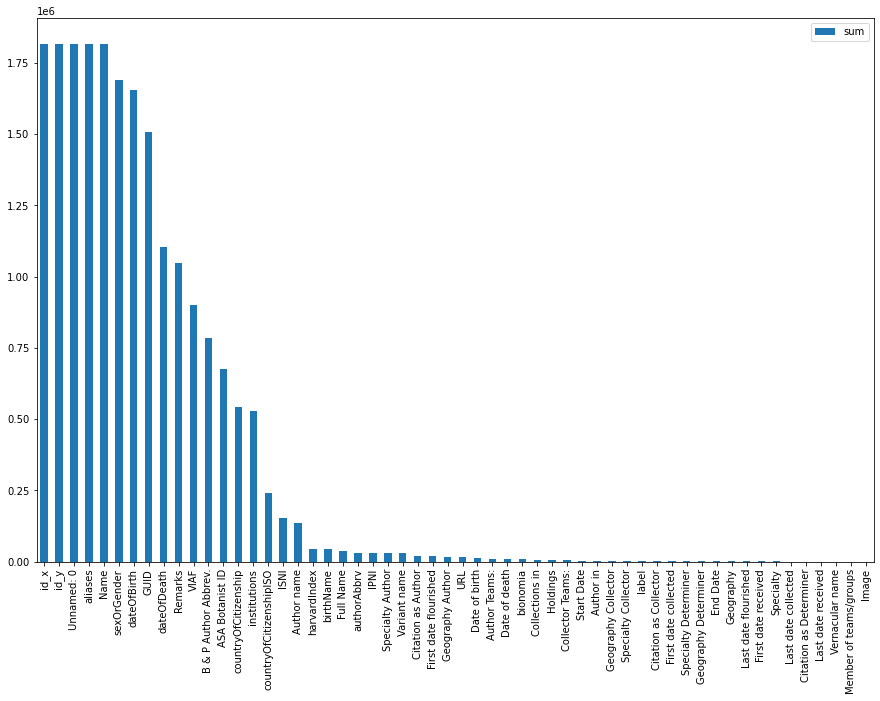

In [180]:
## result2 = pd.merge(wiki_data, harvard_data, how='inner', on=None, left_on='label', right_on='labelName',
##                   left_index=False, right_index=False, sort=False,
##                   suffixes=('_w', '_h'), copy=False)

result2 = wiki_data.merge(harvard_data, on='label')
result2_columns = result2.columns.tolist()
distribution = get_distribution(result2, result2_columns)
temp = distribution.T.sort_values(by=['sum'], ascending=False)
print(temp)
temp.plot.bar(figsize=(15,10))

In [154]:
result2['id_w'].value_counts()

Q23673978    7321
Q29453438    7321
Q25461079    7321
Q25465389    7321
Q25532585    7321
             ... 
Q33667102       1
Q33666870       1
Q33664819       1
Q33664780       1
Q23139          1
Name: id_w, Length: 1897, dtype: int64

ModuleNotFoundError: No module named 'spacy'